In [1]:
import scanpy as sc

adata_interp = sc.read_h5ad('/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/data/adata_interpretable_sec8_final.h5ad')

# Ontology assembly & concept mapping

In [2]:
import re
import pandas as pd
from collections import OrderedDict

# =========================
# 1) Mechanistic channels
# =========================
CHANNEL_REGEX = OrderedDict([
    ("Immune communication", [
        r"\b(immune|immunolog|leukocyte|lymphocyte|myeloid|neutrophil|monocyte|macrophage|dendritic|b[- ]?cell|t[- ]?cell|nk cell|plasmablast|pdc)\b",
        r"\b(cytokine|chemokine|interleukin|il[- ]?\d+|cc[lr]?\d+|cx[cl]\d+|ifn[abg]|interferon|tnf|tumou?r necrosis factor)\b",
        r"\b(mhc|h[la]-[a-z0-9]+|antigen (?:processing|presentation)|cross[- ]?presentation|peptide antigen binding)\b",
        r"\b(checkpoint|pd[- ]?1|pd[- ]?l1|ctla[- ]?4|lag[- ]?3|tigit|tim[- ]?3)\b",
        r"\b(complement|c\d+\s*component|immunological synapse)\b",
        r"\b(degranulation|granule|pattern recognition receptor|tlr|prr)\b",
        r"\bnf[- ]?kappa?b|i[- ]?kappa?b\b",
        r"\bnatural killer\b",
    ]),
    ("Extracellular matrix and structural remodeling", [
        r"\b(extracellular matrix|ecm|matrisome|collagen|laminin|fibronectin)\b",
        r"\b(integrin|itga\d+|itgb\d+|focal adhesion|adhesion)\b",
        r"\b(matrix remodeling|mmp\d+|metalloproteinase|timp)\b",
        r"\b(cytoskeleton|actin|microtubule|intermediate filament|stress fiber|supramolecular fiber)\b",
        r"\b(tight junction|adherens junction|desmosome|junction (?:assembly|organization))\b",
        r"\bstromal|myofibroblast|caf\b",
    ]),
    ("Metabolic communication", [
        r"\b(glycolysis|gluconeogenesis|pentose phosphate|tca cycle|oxidative phosphorylation|oxphos)\b",
        r"\b(lipid|fatty acid|cholesterol|sterol|bile|ketone|peroxisome|beta[- ]?oxidation)\b",
        r"\b(amino acid|glutamine|serine|folate|one[- ]carbon)\b",
        r"\b(mt?or|ampk|metabolic)\b",
        r"\b(lactate|monocarboxylate transporter|mct)\b",
        r"\b(prostaglandin|prostanoid|eicosanoid)\b",
        r"\b(nitric oxide biosynthetic process)\b",
    ]),
    ("Angiogenesis and vascular signaling", [
        r"\b(angiogenesis|vascular|vasculature|blood vessel|endothelial|pericyte|sprouting)\b",
        r"\b(vegf|vegfr|flt1|kdr|tek|tie2)\b",
        r"\b(platelet (?:activation|aggregation)|coagulation|vascular permeability|circulation|blood pressure)\b",
        r"\bnitric[- ]?oxide(?! synthase\b)\b",
    ]),
    ("Hypoxia and stress response", [
        r"\b(hypoxia|hif[- ]?1[aα]?|hypoxic)\b",
        r"\b(oxidative stress|reactive oxygen|ros|nrf2)\b",
        r"\b(er stress|unfolded protein response|upr|atf4|perk|ire1|xbp1)\b",
        r"\b(heat shock|hsp\d+|stress response|senescence)\b",
        r"\b(response to (?:radiation|uv[- ]?b?|oxygen|starvation|metal ion|temperature))\b",
        r"\b(calcium[- ]mediated signaling|intracellular calcium ion homeostasis)\b",
    ]),
    ("Proliferation and DNA damage response", [
        r"\b(cell cycle|mitosis|g1|s phase|g2|m phase|proliferation|e2f targets|myc targets)\b",
        r"\b(dna repair|homologous recombination|non[- ]?homologous end[- ]?joining|mismatch repair|dna damage response)\b",
        r"\b(replication stress|checkpoint kinase|atr|atm|chk1|chk2|p53)\b",
        r"\b(mapk|erk|pi3k|akt|raf|mek|jnk)\b",
        r"\b(receptor tyrosine kinase|rtk|protein kinase activity|autophosphorylation|peptidyl[- ]?tyrosine phosphorylation)\b",
        r"\b(signal(?:ing)? (?:pathway|cascade)|receptor (?:activity|binding)|transducer activity)\b",
        r"\b(insulin[- ]like growth factor|igf|igfbp)\b",
    ]),
    ("Epithelial–mesenchymal transition and migration", [
        r"\b(emt|epithelial[- ]?mesenchymal)\b",
        r"\b(migration|motility|invasion|filopodia|lamellipodia|rhoa|rac1|cdc42)\b",
        r"\b(epithelial polarity|junction reorganization|cell[- ]?cell fusion|syncytium)\b",
        r"\b(wound healing|morphogenesis|epithelial (?:cell )?differentiation)\b",
        r"\b(tgf[- ]?β|transforming growth factor beta)\b",
    ]),
    ("Vesicle trafficking & secretion", [
        r"\b(golgi|early endosome|late endosome|lysosome|lytic vacuole|secretory granule)\b",
        r"\b(vesicle|endocytosis|exocytosis|plasma membrane invagination)\b",
        r"\b(protein transport|protein localization|establishment of localization)\b",
        r"\b(peptide secretion|regulation of secretion)\b",
    ]),
])

# ==================================
# 2) Generic THEMES (for leftovers)
#    (kept distinct, not used for CCC)
# ==================================
GENERIC_REGEX = OrderedDict([
    ("Generic: Development & Morphogenesis", [
        r"\b(system|multicellular organism|organ|tissue|embryo(?:nic)?|morphogenesis|development)\b",
        r"\b(neurogenesis|mesoderm|metanephros|renal tubule|pancreas|cardiac chamber|skin|muscle)\b",
        r"\b(implantation|epiboly)\b",
    ]),
    ("Generic: Localization & Transport", [
        r"\b(localization|transport|protein localization|establishment of localization)\b",
        r"\b(intracellular transport|organelle lumen|plasma membrane)\b",
        r"\b(vesicle membrane|plasma membrane invagination)\b",
    ]),
    ("Generic: Signaling (broad/unspecified)", [
        r"\b(signal(?:ing)? (?:pathway|cascade)|signaling receptor regulator activity|intracellular signaling cassette)\b",
        r"\b(positive|negative) regulation of .+\b",
        r"\b(regulation of (?:biological process|.* differentiation|.* activation|.* secretion|.* organization))\b",
        r"\b(transcription (?:co)?activator binding|transcription coregulator binding|rna polymerase ii)\b",
    ]),
    ("Generic: Metabolism & Biosynthesis (broad)", [
        r"\b(biosynthetic process|metabolic process|macromolecule modification)\b",
        r"\b(phosphotransferase activity, alcohol group as acceptor)\b",
    ]),
    ("Generic: Homeostasis & Ion balance", [
        r"\b(homeostasis|ion homeostasis|monoatomic cation|inorganic ion)\b",
        r"\b(calcium[- ]mediated signaling)\b",
    ]),
    ("Generic: Cell death & Apoptosis (broad)", [
        r"\b(programmed cell death|apoptotic|necroptotic)\b",
    ]),
    ("Generic: Response to Stimulus (broad)", [
        r"^response to .+$",
        r"\b(detection of biotic stimulus|response to (?:alcohol|acid chemical|temperature|metal ion|uv|radiation|oxygen|starvation))\b",
    ]),
    ("Generic: Host–pathogen / Symbiont", [
        r"\b(symbiont entry into host( cell)?|modulation by symbiont|disruption of.* in another organism)\b",
    ]),
    ("Generic: Cell population/number", [
        r"\b(maintenance of cell number)\b",
    ]),
])

GENERIC_REGEX.update({
    "Generic: Binding & Catalytic Activity": [
        r"\b(binding|catalytic activity|enzyme activity|protease binding|phosphotransferase)\b",
        r"\b(kinase activator|non[- ]membrane spanning protein tyrosine kinase)\b",
    ],
    "Generic: Cellular Response (unspecified)": [
        r"cellular response to .+",
    ],
    "Generic: Neural/Glial": [
        r"\b(glial|microglial|neurogenesis|somatodendritic)\b",
    ],
})

GENERIC_CHANNELS = set(GENERIC_REGEX.keys())

# =========================
# 3) Backfills & Overrides
# =========================
BACKFILL = OrderedDict([
    (r"\bnf[- ]?kappa?b|i[- ]?kappa?b\b", "Immune communication"),
    (r"\b(peptide antigen binding|immune system process|leukocyte|lymphocyte|humoral immune response)\b", "Immune communication"),
    (r"\b(platelet (?:activation|aggregation)|coagulation|vascular process|blood circulation|blood pressure)\b", "Angiogenesis and vascular signaling"),
    (r"\b(cytoskeleton organization|stress fiber|supramolecular fiber organization|adherens junction|tight junction)\b", "Extracellular matrix and structural remodeling"),
    (r"\b(epithelial (?:cell )?differentiation|epithelial tube formation|junction (?:assembly|organization)|wound healing)\b", "Epithelial–mesenchymal transition and migration"),
    (r"\b(pi3k|akt|mapk|erk|jnk|rtk|protein kinase activity|autophosphorylation|peptidyl[- ]?tyrosine phosphorylation)\b", "Proliferation and DNA damage response"),
    (r"\b(biosynthetic process|steroid biosynthetic process|monooxygenase activity|prostanoid|prostaglandin)\b", "Metabolic communication"),
    (r"\b(nitric[- ]?oxide synthase regulator activity)\b", "Angiogenesis and vascular signaling"),
])

EXACT_OVERRIDES = {
    # Vesicle/secretory
    "Golgi apparatus": "Vesicle trafficking & secretion",
    "early endosome": "Vesicle trafficking & secretion",
    "lysosome localization": "Vesicle trafficking & secretion",
    "lytic vacuole": "Vesicle trafficking & secretion",
    "plasma membrane": "Vesicle trafficking & secretion",
    "plasma membrane invagination": "Vesicle trafficking & secretion",
    "protein transport": "Vesicle trafficking & secretion",
    "protein localization": "Vesicle trafficking & secretion",
    "establishment of localization": "Vesicle trafficking & secretion",
    "establishment of protein localization to extracellular region": "Vesicle trafficking & secretion",
    "peptide secretion": "Vesicle trafficking & secretion",
    # Growth factor
    "insulin-like growth factor binding": "Proliferation and DNA damage response",
    "insulin-like growth factor binding protein complex": "Proliferation and DNA damage response",
    # Vascular NO synthase regulator
    "nitric-oxide synthase regulator activity": "Angiogenesis and vascular signaling",
}

# =========================
# 4) Parser helpers
# =========================
REG_RE  = re.compile(r"^(?:positive|negative)\s*regulation of (.+)$", re.I)
RESP_RE = re.compile(r"^response to (.+)$", re.I)

def _strip_quotes(s: str) -> str:
    return s.strip().strip('"').strip("'")

def _match_first(regex_dict, text):
    for channel, pats in regex_dict.items():
        for p in pats:
            if re.search(p, text, flags=re.I):
                return channel
    return None

def classify_term(term, multi=True):
    raw = str(term or "")
    s   = raw.lower().strip()

    # 0) exact overrides
    if raw in EXACT_OVERRIDES:
        ch = EXACT_OVERRIDES[raw]
        return ch, [ch] if multi else [], ch in GENERIC_CHANNELS, (ch if ch in GENERIC_CHANNELS else None)

    # 1) unwrap "regulation of X"
    m = REG_RE.match(s)
    if m:
        inner = _strip_quotes(m.group(1))
        ch, mlist, is_gen, theme = classify_term(inner, multi=multi)
        # If inner is still unclassified, fall back to Generic Signaling
        if ch == "Unclassified":
            return "Generic: Signaling (broad/unspecified)", (["Generic: Signaling (broad/unspecified)"] if multi else []), True, "Generic: Signaling (broad/unspecified)"
        return ch, mlist, is_gen, theme

    # 2) unwrap "response to Y"
    m = RESP_RE.match(s)
    if m:
        inner = _strip_quotes(m.group(1))
        # quick immune hook
        if re.search(r"\btumou?r\b|\bpathogen\b|\bbacteria|virus\b", inner, re.I):
            return "Immune communication", ["Immune communication"] if multi else [], False, None
        # stress hook
        if re.search(r"\b(uv|radiation|oxygen|starvation|metal ion|temperature|hypoxi)\b", inner, re.I):
            return "Hypoxia and stress response", ["Hypoxia and stress response"] if multi else [], False, None
        ch, mlist, is_gen, theme = classify_term(inner, multi=multi)
        if ch == "Unclassified":
            return "Generic: Response to Stimulus (broad)", (["Generic: Response to Stimulus (broad)"] if multi else []), True, "Generic: Response to Stimulus (broad)"
        return ch, mlist, is_gen, theme

    # 3) mechanistic channels
    ch = _match_first(CHANNEL_REGEX, s)
    if ch:
        # also collect any other mechanistic matches for channel_multi
        multis = []
        if multi:
            for alt, pats in CHANNEL_REGEX.items():
                if alt == ch: 
                    multis.append(alt); continue
                if any(re.search(p, s, re.I) for p in pats):
                    multis.append(alt)
            multis = sorted(set(multis))
        return ch, multis, False, None

    # 4) backfills to mechanistic
    for p, mech in BACKFILL.items():
        if re.search(p, s, flags=re.I):
            return mech, [mech] if multi else [], False, None

    # 5) generic themes
    gen = _match_first(GENERIC_REGEX, s)
    if gen:
        return gen, [gen] if multi else [], True, gen

    # 6) still nothing
    return "Unclassified", [], True, None

def classify_terms_to_df(terms, multi=True):
    rows = []
    for t in terms:
        ch, mlist, is_gen, theme = classify_term(t, multi=multi)
        rows.append({
            "concept": t,
            "channel_primary": ch,
            "channel_multi": ";".join(mlist) if mlist else "",
            "is_generic": bool(is_gen),
            "generic_theme": theme if is_gen else None,
        })
    return pd.DataFrame(rows)

# =========================
# 5) Usage
# =========================
concepts = adata_interp.var_names.astype(str)   # your interpretable-feature names
df = classify_terms_to_df(concepts)
# print(df["channel_primary"].value_counts().sort_values(ascending=False))

# —— Downstream tip: keep mechanistic channels only for crosstalk inference ——
df_mech = df[~df["is_generic"] & (df["channel_primary"] != "Unclassified")].copy()
df_generic = df[df["is_generic"]].copy()  # for reporting/QA but excluded from scoring

# 6) Write onto adata_interp.var (safe merge by index)
df = df.set_index("concept").reindex(adata_interp.var_names)

# Ensure expected columns exist
for c in ["channel_primary", "channel_multi", "is_generic", "generic_theme"]:
    if c not in df.columns:
        df[c] = pd.NA

adata_interp.var["channel_primary"]  = pd.Categorical(df["channel_primary"].fillna("Unclassified"))
adata_interp.var["channel_multi"]    = df["channel_multi"].fillna("")
adata_interp.var["is_generic"]       = df["is_generic"].fillna(True).astype(bool)
adata_interp.var["generic_theme"]    = pd.Categorical(df["generic_theme"].fillna(""))

# 7) QC overview
counts = adata_interp.var["channel_primary"].value_counts(dropna=False).sort_values(ascending=False)
print("\n[Channel coverage]")
print(counts)

n = adata_interp.n_vars
is_generic_mask = adata_interp.var["is_generic"].values
core_mask = (~is_generic_mask) & (adata_interp.var["channel_primary"] != "Unclassified")
n_core = int(core_mask.sum())
n_generic = int(is_generic_mask.sum())
n_unclassified = int((adata_interp.var["channel_primary"] == "Unclassified").sum())

print(f"\nTotals: core={n_core}  generic={n_generic}  unclassified={n_unclassified}  (N={n})")

# (Optional) persist the annotated concepts table
# adata_interp.write_h5ad(
#     "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/data/adata_interpretable_sec8_final.h5ad",
#     compression="lzf"
# )


[Channel coverage]
channel_primary
Immune communication                               117
Proliferation and DNA damage response               33
Metabolic communication                             32
Generic: Development & Morphogenesis                29
Generic: Signaling (broad/unspecified)              27
Epithelial–mesenchymal transition and migration     24
Angiogenesis and vascular signaling                 23
Vesicle trafficking & secretion                     19
Unclassified                                        19
Hypoxia and stress response                         14
Extracellular matrix and structural remodeling      11
Generic: Binding & Catalytic Activity               10
Generic: Localization & Transport                    7
Generic: Cellular Response (unspecified)             5
Generic: Host–pathogen / Symbiont                    5
Generic: Response to Stimulus (broad)                5
Generic: Cell death & Apoptosis (broad)              4
Generic: Neural/Glial        

# Micro (cell-pairs) crosstalk scoring

In [ ]:
# # ============================================================
# # Phase 2 (DAG-aware) — Cell–pair crosstalk on 393 GO features
# # ============================================================
# import re
# import numpy as np
# # import pandas as pd
# import scipy.sparse as sp
# from collections import defaultdict, deque
# from sklearn.neighbors import NearestNeighbors
# from IPython.display import display

# # --------------------------------
# # 0) Inputs (from Phase 1)
# # --------------------------------
# adata = adata_interp  # interpretable AnnData (cells x ~393 concepts)

# # ----------------------------------------------------------
# # A) Map your 393 concept names -> GO IDs (robust, 3 passes)
# # ----------------------------------------------------------
# csv_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/cosmx_lung_human_gp_go_kegg_reactome.csv"
# obo_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo"

# # 1) Load g:Profiler table and keep GO rows (GO:BP/MF/CC)
# gp = pd.read_csv(csv_path)
# if "source" in gp.columns:
#     gp_src = gp["source"].astype(str).str.upper().str.strip()
#     gp_go  = gp[gp_src.str.startswith("GO", na=False)].copy()
# else:
#     gp_go = gp.copy()

# # 2) Standardize column names (name + id + optional namespace)
# name_col = None
# for cand in ["term_name", "name", "term", "native"]:
#     if cand in gp_go.columns:
#         name_col = cand; break
# if name_col is None:
#     raise ValueError("g:Profiler CSV missing a term-name column (e.g. 'term_name' or 'name').")

# id_col = None
# for cand in ["term_id", "native", "term", "id"]:
#     if cand in gp_go.columns:
#         id_col = cand; break
# if id_col is None:
#     raise ValueError("g:Profiler CSV missing an ID column (e.g. 'term_id' or 'native').")

# ns_col = None
# for cand in ["namespace", "term_namespace", "go_domain"]:
#     if cand in gp_go.columns:
#         ns_col = cand; break

# gp_go["__name_norm"] = gp_go[name_col].astype(str).str.strip().str.lower()
# gp_go["__id_norm"]   = gp_go[id_col].astype(str).str.strip()

# if ns_col is not None:
#     ns_rank = {
#         "BIOLOGICAL_PROCESS": 0, "biological_process": 0,
#         "MOLECULAR_FUNCTION": 1, "molecular_function": 1,
#         "CELLULAR_COMPONENT": 2, "cellular_component": 2
#     }
#     gp_go["__ns_rank"] = gp_go[ns_col].map(ns_rank).fillna(9).astype(int)
#     gp_go = (gp_go
#              .sort_values(["__name_norm", "__ns_rank"])
#              .drop_duplicates("__name_norm", keep="first"))
# else:
#     gp_go = gp_go.drop_duplicates("__name_norm", keep="first")

# # 3) Build OBO name→ID map for fallback
# try:
#     from goatools.obo_parser import GODag
#     go_dag_for_names = GODag(obo_path)
#     name_to_id = {}
#     for go_id, rec in go_dag_for_names.items():
#         nm = str(rec.name or "").strip().lower()
#         if nm and nm not in name_to_id:
#             name_to_id[nm] = go_id
# except Exception as e:
#     go_dag_for_names, name_to_id = None, {}
#     print(f"[WARN] Could not load GO OBO for name fallback ({type(e).__name__}: {e}).")

# # 4) Map your feature names → GO IDs (3 passes)
# var = adata.var.copy()
# var["__name_norm"] = var.index.astype(str).str.strip().str.lower()

# # Pass A: by name via g:Profiler
# var["go_id"] = var["__name_norm"].map(gp_go.set_index("__name_norm")["__id_norm"])

# # Pass B: if your var_names already look like GO:0000000
# looks_like_go = var.index.to_series().astype(str).str.match(r"^GO:\d{7}$", na=False)
# var.loc[var["go_id"].isna() & looks_like_go, "go_id"] = var.index[looks_like_go]

# # Pass C: OBO fallback by exact name (if OBO loaded)
# if name_to_id:
#     mask_missing = var["go_id"].isna()
#     var.loc[mask_missing, "go_id"] = var.loc[mask_missing, "__name_norm"].map(name_to_id)

# # Commit to AnnData
# adata.var["go_id"] = var["go_id"].astype("string")

# n_mapped = adata.var["go_id"].notna().sum()
# print(f"[GO mapping] mapped {n_mapped} / {adata.n_vars} concepts to GO IDs")
# if n_mapped < adata.n_vars:
#     print("[Unmapped examples]")
#     display(adata.var.loc[adata.var["go_id"].isna()].head(15)[["go_id"]])

# # ----------------------------------------------------------
# # B) Build GO parent map and semantic kernel G
# # ----------------------------------------------------------
# def build_parent_map_from_go_obo(obo_path):
#     from goatools.obo_parser import GODag
#     go = GODag(obo_path)
#     pm = {}
#     for go_id, rec in go.items():
#         pm[go_id] = [p.id for p in rec.parents]  # direct is_a parents
#     return pm

# # X_terms (cells x T)
# X_terms_raw = adata.X
# if sp.issparse(X_terms_raw):
#     N, T = X_terms_raw.shape
# else:
#     X_terms_raw = np.asarray(X_terms_raw, dtype=np.float32)
#     N, T = X_terms_raw.shape
# terms = adata.var_names.astype(str).tolist()

# # sanity: need Phase 1 annotations
# req_cols = {"channel_primary", "is_generic"}
# if not req_cols.issubset(adata.var.columns):
#     raise ValueError("Missing adata.var[['channel_primary','is_generic']]. Run Phase 1 first.")

# # Choose IDs: prefer mapped go_id
# if adata.var["go_id"].notna().any():
#     go_col = adata.var["go_id"].astype("string")
#     fallback_series = pd.Series(adata.var_names.astype(str), index=adata.var.index)

#     go_ids = go_col.fillna(fallback_series).astype(str).tolist()
# else:
#     go_ids = terms

# # Parent map
# try:
#     parent_map = build_parent_map_from_go_obo(obo_path)
# except Exception as e:
#     parent_map = {}
#     print(f"[WARN] Could not parse OBO for DAG ({type(e).__name__}: {e}). Using identity kernel.")

# in_dag_mask = np.array([g in parent_map for g in go_ids], dtype=bool)
# n_in = int(in_dag_mask.sum())
# print(f"[GO DAG] recognized: {n_in} / {T} terms")

# def collect_with_ancestors(term_list, parent_map, max_hops=6):
#     nodes = set(term_list)
#     for t in term_list:
#         q = deque([(t, 0)])
#         seen = {t}
#         while q:
#             cur, d = q.popleft()
#             if d == max_hops:
#                 continue
#             for p in parent_map.get(cur, []):
#                 if p not in seen:
#                     seen.add(p); q.append((p, d+1))
#                     nodes.add(p)
#     return nodes

# def shortest_path_distances(nodes, parent_map):
#     adj = defaultdict(set)
#     for child in nodes:
#         for p in parent_map.get(child, []):
#             if p in nodes:
#                 adj[child].add(p)
#                 adj[p].add(child)

#     nodes_list = list(nodes)
#     idx = {n: i for i, n in enumerate(nodes_list)}
#     D = np.full((len(nodes_list), len(nodes_list)), np.inf, dtype=np.float32)
#     for i, src in enumerate(nodes_list):
#         D[i, i] = 0.0
#         q = deque([src])
#         visited = {src}
#         while q:
#             u = q.popleft()
#             for v in adj[u]:
#                 if v not in visited:
#                     visited.add(v)
#                     D[i, idx[v]] = D[i, idx[u]] + 1.0
#                     q.append(v)
#     return nodes_list, idx, D

# HOPS_FOR_GRAPH = 6
# tau = 3.0

# if n_in > 0 and len(parent_map) > 0:
#     dag_nodes = collect_with_ancestors([g for g in go_ids if g in parent_map],
#                                        parent_map, max_hops=HOPS_FOR_GRAPH)
#     nodes_all, idx_all, D_all = shortest_path_distances(dag_nodes, parent_map)

#     # Build D_terms (T x T) using indices into D_all
#     idx_in_all = np.array([idx_all.get(g, -1) for g in go_ids], dtype=int)
#     hits = idx_in_all >= 0
#     D_terms = np.full((T, T), np.inf, dtype=np.float32)
#     for a in range(T):
#         ia = idx_in_all[a]
#         if ia < 0:
#             continue
#         row = D_all[ia]
#         D_terms[a, hits] = row[idx_in_all[hits]]

#     G = np.exp(-D_terms / float(tau)).astype(np.float32)
#     np.fill_diagonal(G, 1.0)
#     G[np.isinf(D_terms)] = 0.0
#     if np.any(G > 0):
#         print(f"[Kernel] τ={tau} | G>0 min={G[G>0].min():.3g}, median={np.median(G[G>0]):.3g}, max={G.max():.3g}")
#     else:
#         print("[Kernel] Warning: no finite DAG paths; using identity kernel.")
#         G = np.eye(T, dtype=np.float32)
# else:
#     print("[Kernel] Using identity kernel (no recognized GO coverage or DAG unavailable).")
#     G = np.eye(T, dtype=np.float32)

# # Optional Information Content (IC) weights (feature specificity)
# def compute_term_ic(X):
#     if sp.issparse(X):
#         nz = np.array(X.getnnz(axis=0)).ravel()
#         n  = X.shape[0]
#     else:
#         nz = np.count_nonzero(X, axis=0)
#         n  = X.shape[0]
#     p = np.clip(nz / max(n, 1), 1e-6, 1.0)
#     return (-np.log(p)).astype(np.float32)

# USE_IC = True
# IC = compute_term_ic(X_terms_raw) if USE_IC else np.ones(T, dtype=np.float32)
# W = IC  # elementwise term weights

# # ----------------------------------------------------------
# # C) Channel term sets (mechanistic only)
# # ----------------------------------------------------------
# df_var = adata.var[["channel_primary", "is_generic"]].copy()
# mech_mask = (~df_var["is_generic"].fillna(False)) & df_var["channel_primary"].notna() & (df_var["channel_primary"] != "Unclassified")
# channels = sorted(df_var.loc[mech_mask, "channel_primary"].unique().tolist())

# terms_idx_by_ch = {}
# for c in channels:
#     mask_c = mech_mask & (adata.var["channel_primary"] == c)
#     idx_c  = np.where(mask_c.values)[0]
#     terms_idx_by_ch[c] = idx_c

# print(f"[Channels] {len(channels)} mechanistic channels: {channels}")

# # ----------------------------------------------------------
# # D) Spatial radius graph (~20 neighbors)
# # ----------------------------------------------------------
# if "spatial" in adata.obsm:
#     X_nn = np.asarray(adata.obsm["spatial"], dtype=np.float32)
#     space_name = "spatial"
# else:
#     from sklearn.decomposition import PCA
#     X_dense_for_pca = X_terms_raw.toarray() if sp.issparse(X_terms_raw) else X_terms_raw
#     X_nn = PCA(n_components=min(10, T), random_state=0).fit_transform(X_dense_for_pca)
#     space_name = "terms-PCA"

# target_k = 20
# rng = np.random.default_rng(0)
# sub = rng.choice(adata.n_obs, size=min(2000, adata.n_obs), replace=False)
# nbrs_sub = NearestNeighbors(n_neighbors=target_k+1, metric="euclidean").fit(X_nn[sub])
# dists_sub, _ = nbrs_sub.kneighbors(X_nn[sub], n_neighbors=target_k+1, return_distance=True)
# RADIUS = float(np.median(dists_sub[:, target_k])) if dists_sub.shape[1] > target_k else float(np.median(dists_sub[:, -1]))
# print(f"[Neighbors] Auto radius (target_k={target_k}): RADIUS={RADIUS:.3g} in {space_name} space")

# nbrs_full = NearestNeighbors(radius=RADIUS, metric="euclidean").fit(X_nn)
# neighbors = []
# all_d = []
# for i in range(adata.n_obs):
#     di, ii = nbrs_full.radius_neighbors(X_nn[i:i+1], radius=RADIUS, return_distance=True)
#     di, ii = di[0], ii[0]
#     mask = (ii != i)
#     ii, di = ii[mask], di[mask]
#     neighbors.append((ii, di))
#     if di.size > 0:
#         all_d.append(di)
# all_d = np.concatenate(all_d) if len(all_d) else np.array([1.0], dtype=np.float32)
# sigma = float(np.median(all_d)) if all_d.size > 0 else 1.0
# sigma = max(sigma, 1e-6)
# print(f"[Neighbors] median edge length σ={sigma:.3g}")

# def w_spatial(d):
#     return np.exp(-(d**2) / (sigma**2))

# # ----------------------------------------------------------
# # E) DAG-aware per-edge scoring:
# #     s_c(i,j) = (f_i[Jc] ⊙ W[Jc])^T · G[Jc,Jc] · (f_j[Jc] ⊙ W[Jc])
# #   (with term-wise z-scoring first)
# # ----------------------------------------------------------
# # Prepare dense term matrix and z-score by term
# if sp.issparse(X_terms_raw):
#     X_dense = X_terms_raw.toarray().astype(np.float32)
# else:
#     X_dense = X_terms_raw.astype(np.float32)

# mu = X_dense.mean(axis=0, keepdims=True)
# sd = X_dense.std(axis=0, keepdims=True); sd[sd < 1e-8] = 1.0
# Xz = (X_dense - mu) / sd  # [N, T]

# # Cache per-channel kernel blocks and weights
# G_blocks = {c: G[np.ix_(idxs, idxs)] for c, idxs in terms_idx_by_ch.items()}
# W_blocks = {c: W[terms_idx_by_ch[c]] for c in channels}

# rows = []
# N = adata.n_obs
# for i in range(N):
#     js, ds = neighbors[i]
#     if js is None or len(js) == 0:
#         continue
#     # keep upper triangle (i < j)
#     mask = js > i
#     js, ds = js[mask], ds[mask]
#     if js.size == 0:
#         continue

#     fi = Xz[i, :]
#     for j, d in zip(js, ds):
#         fj = Xz[j, :]
#         w = w_spatial(float(d))
#         for c in channels:
#             J  = terms_idx_by_ch[c]
#             if J.size == 0:
#                 continue
#             Gi = G_blocks[c]        # |J| x |J|
#             wi = W_blocks[c]        # |J|
#             vi = (fi[J] * wi)       # |J|
#             vj = (fj[J] * wi)       # |J|
#             s  = float(vi @ (Gi @ vj))
#             if s <= 0:
#                 continue
#             rows.append((i, j, c, s, w, s*w, float(d)))

# edge_df = pd.DataFrame(rows, columns=["i", "j", "channel", "score_raw", "w_spatial", "score_weighted", "distance"])
# print(f"\n[Edges] long rows = {len(edge_df):,} ; unique pairs = {edge_df[['i','j']].drop_duplicates().shape[0]:,}")

# # ----------------------------------------------------------
# # F) Per-channel normalization & QC
# # ----------------------------------------------------------
# def zscore_per_channel(df, col="score_weighted"):
#     out = []
#     for c, sub in df.groupby("channel", sort=False):
#         x = sub[col].to_numpy()
#         mu, sd = x.mean(), x.std()
#         z = np.zeros_like(x) if sd < 1e-12 else (x - mu) / sd
#         tmp = sub.copy()
#         tmp["z"] = z
#         out.append(tmp)
#     return pd.concat(out, axis=0, ignore_index=True)

# if len(edge_df):
#     edge_df = zscore_per_channel(edge_df, col="score_weighted")

#     print("\n[Channel medians of z] (should be ~0):")
#     print(edge_df.groupby("channel")["z"].median().sort_values())

#     print("\n[Top channels by raw median weighted score]")
#     print(edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False).head(10))

#     print("\n[Examples] top edges by z within each channel")
#     examples = edge_df.sort_values(["channel", "z"], ascending=[True, False])\
#                       .groupby("channel").head(3)
#     display(examples)

#     # keep only strong edges if desired
#     Z_MIN = 1.5
#     edge_strong = edge_df[edge_df["z"] >= Z_MIN].copy()
#     print(f"\n[Strong edges] z>={Z_MIN}: {len(edge_strong):,} rows")

#     # You can persist if needed:
#     # edge_df.to_parquet("/path/to/crosstalk_edges_dag.parquet", index=False)
#     # edge_strong.to_parquet("/path/to/crosstalk_edges_dag_strong.parquet", index=False)
# else:
#     print("[Warn] No positive edges scored; check inputs or reduce radius/normalization.")

/tmp/ipykernel_1371329/1480375030.py:24: DtypeWarning: Columns (10,15,17,25,57,82,95,126,135,137,143,147,163,173,182,214,215,217,218,219,238,256,263,273,274,297,339,356,358,375,377,419,426,428,462,463,491,495,505,514,537,558,607,620,628,629,633,661,662,663,668,673,703,712,716,737,761,763,773,783,787,788,789,790,792,801,802,807,810,853,888,893,900,906,922,926,946) have mixed types. Specify dtype option on import or set low_memory=False.
  gp = pd.read_csv(csv_path)


/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO mapping] mapped 393 / 393 concepts to GO IDs
/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO DAG] recognized: 391 / 393 terms
[Kernel] τ=3.0 | G>0 min=0.00483, median=0.0695, max=1
[Channels] 8 mechanistic channels: ['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion']
[Neighbors] Auto radius (target_k=20): RADIUS=1.1e+03 in spatial space
[Neighbors] median edge length σ=770


KeyboardInterrupt: 

In [3]:
# fast

# ============================================================
# Phase 2 (DAG-aware) — Cell–pair crosstalk on 393 GO features
#   • Maps concept names → GO IDs (from g:Profiler + OBO fallback)
#   • Builds GO DAG kernel G (exp(-dist/tau))
#   • IC term weighting
#   • Mechanistic channels from Phase 1
#   • FAST scoring: per-channel low-rank embeddings (eigentruncation)
#     and kNN edges with spatial Gaussian weights
# ============================================================

import re
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import defaultdict, deque
from sklearn.neighbors import NearestNeighbors
from IPython.display import display

# ----------------------------
# 0) Inputs (from Phase 1)
# ----------------------------
adata = adata_interp  # AnnData with ~393 interpretable features
csv_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/cosmx_lung_human_gp_go_kegg_reactome.csv"
obo_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo"

# ============================================================
# A) Map your concept names → GO IDs (3 passes)
# ============================================================
gp = pd.read_csv(csv_path)
if "source" in gp.columns:
    gp_src = gp["source"].astype(str).str.upper().str.strip()
    gp_go  = gp[gp_src.str.startswith("GO", na=False)].copy()
else:
    gp_go = gp.copy()

# standardize column names
name_col = None
for cand in ["term_name", "name", "term", "native", "description"]:
    if cand in gp_go.columns:
        name_col = cand; break
if name_col is None:
    raise ValueError("g:Profiler CSV missing a term-name column (e.g. 'term_name').")

id_col = None
for cand in ["term_id", "native", "term", "id"]:
    if cand in gp_go.columns:
        id_col = cand; break
if id_col is None:
    raise ValueError("g:Profiler CSV missing an ID column (e.g. 'term_id').")

ns_col = None
for cand in ["namespace", "term_namespace", "go_domain"]:
    if cand in gp_go.columns:
        ns_col = cand; break

gp_go["__name_norm"] = gp_go[name_col].astype(str).str.strip().str.lower()
gp_go["__id_norm"]   = gp_go[id_col].astype(str).str.strip()
if ns_col is not None:
    ns_rank = {
        "BIOLOGICAL_PROCESS": 0, "biological_process": 0,
        "MOLECULAR_FUNCTION": 1, "molecular_function": 1,
        "CELLULAR_COMPONENT": 2, "cellular_component": 2
    }
    gp_go["__ns_rank"] = gp_go[ns_col].map(ns_rank).fillna(9).astype(int)
    gp_go = (gp_go
             .sort_values(["__name_norm", "__ns_rank"])
             .drop_duplicates("__name_norm", keep="first"))
else:
    gp_go = gp_go.drop_duplicates("__name_norm", keep="first")

# OBO fallback name→ID
try:
    from goatools.obo_parser import GODag
    go_dag_for_names = GODag(obo_path)
    name_to_id = {}
    for go_id, rec in go_dag_for_names.items():
        nm = str(rec.name or "").strip().lower()
        if nm and nm not in name_to_id:
            name_to_id[nm] = go_id
except Exception as e:
    name_to_id = {}
    print(f"[WARN] Could not load OBO for name fallback ({type(e).__name__}: {e}).")

# map your var names
var = adata.var.copy()
var["__name_norm"] = var.index.astype(str).str.strip().str.lower()
# A: CSV by name
var["go_id"] = var["__name_norm"].map(gp_go.set_index("__name_norm")["__id_norm"])
# B: var_names already GO-like
looks_like_go = var.index.to_series().astype(str).str.match(r"^GO:\d{7}$", na=False)
var.loc[var["go_id"].isna() & looks_like_go, "go_id"] = var.index[looks_like_go]
# C: OBO fallback
if name_to_id:
    mask_missing = var["go_id"].isna()
    var.loc[mask_missing, "go_id"] = var.loc[mask_missing, "__name_norm"].map(name_to_id)

# persist mapping
adata.var["go_id"] = var["go_id"].astype("string")
n_mapped = int(adata.var["go_id"].notna().sum())
print(f"[GO mapping] mapped {n_mapped} / {adata.n_vars} concepts to GO IDs")
if n_mapped < adata.n_vars:
    print("[Unmapped examples]")
    display(adata.var.loc[adata.var["go_id"].isna()].head(10)[["go_id"]])

# ============================================================
# B) Build GO parent map and DAG kernel G
# ============================================================
def build_parent_map_from_go_obo(obo_path):
    from goatools.obo_parser import GODag
    go = GODag(obo_path)
    pm = {}
    for go_id, rec in go.items():
        pm[go_id] = [p.id for p in rec.parents]  # direct 'is_a' parents
    return pm

X_terms_raw = adata.X
if sp.issparse(X_terms_raw):
    N, T = X_terms_raw.shape
else:
    X_terms_raw = np.asarray(X_terms_raw, dtype=np.float32)
    N, T = X_terms_raw.shape
terms = adata.var_names.astype(str).tolist()

# sanity: need Phase 1 channel annotations
req_cols = {"channel_primary", "is_generic"}
if not req_cols.issubset(adata.var.columns):
    raise ValueError("Missing adata.var[['channel_primary','is_generic']]. Run Phase 1 first.")

# prefer mapped GO IDs
go_ids = adata.var["go_id"]
fallback_series = pd.Series(adata.var_names.astype(str), index=adata.var.index)
go_ids = go_ids.fillna(fallback_series).astype(str).tolist()

# parent map
try:
    parent_map = build_parent_map_from_go_obo(obo_path)
except Exception as e:
    parent_map = {}
    print(f"[WARN] Could not parse OBO ({type(e).__name__}: {e}). Using identity kernel.")

in_dag_mask = np.array([g in parent_map for g in go_ids], dtype=bool)
n_in = int(in_dag_mask.sum())
print(f"[GO DAG] recognized: {n_in} / {T} terms")

def collect_with_ancestors(term_list, parent_map, max_hops=6):
    nodes = set(term_list)
    for t in term_list:
        q = deque([(t, 0)])
        seen = {t}
        while q:
            cur, d = q.popleft()
            if d == max_hops: 
                continue
            for p in parent_map.get(cur, []):
                if p not in seen:
                    seen.add(p); q.append((p, d+1))
                    nodes.add(p)
    return nodes

def shortest_path_distances(nodes, parent_map):
    adj = defaultdict(set)
    for child in nodes:
        for p in parent_map.get(child, []):
            if p in nodes:
                adj[child].add(p)
                adj[p].add(child)
    nodes_list = list(nodes)
    idx = {n:i for i,n in enumerate(nodes_list)}
    D = np.full((len(nodes_list), len(nodes_list)), np.inf, dtype=np.float32)
    for i, src in enumerate(nodes_list):
        D[i, i] = 0.0
        q = deque([src])
        visited = {src}
        while q:
            u = q.popleft()
            for v in adj[u]:
                if v not in visited:
                    visited.add(v)
                    D[i, idx[v]] = D[i, idx[u]] + 1.0
                    q.append(v)
    return nodes_list, idx, D

# kernel params
TAU = 3.0  # exp distance temperature

if n_in > 0 and len(parent_map) > 0:
    dag_nodes = collect_with_ancestors([g for g in go_ids if g in parent_map],
                                       parent_map, max_hops=6)
    nodes_all, idx_all, D_all = shortest_path_distances(dag_nodes, parent_map)
    idx_in_all = np.array([idx_all.get(g, -1) for g in go_ids], dtype=int)
    hits = idx_in_all >= 0
    D_terms = np.full((T, T), np.inf, dtype=np.float32)
    for a in range(T):
        ia = idx_in_all[a]
        if ia < 0: 
            continue
        row = D_all[ia]
        D_terms[a, hits] = row[idx_in_all[hits]]

    G = np.exp(-D_terms / float(TAU)).astype(np.float32)
    np.fill_diagonal(G, 1.0)
    G[np.isinf(D_terms)] = 0.0
    if np.any(G > 0):
        print(f"[Kernel] τ={TAU} | G>0 min={G[G>0].min():.3g}, median={np.median(G[G>0]):.3g}, max={G.max():.3g}")
    else:
        print("[Kernel] Warning: no finite DAG paths; using identity kernel.")
        G = np.eye(T, dtype=np.float32)
else:
    print("[Kernel] Using identity kernel (no recognized GO coverage or DAG unavailable).")
    G = np.eye(T, dtype=np.float32)

# IC weights (term specificity)
def compute_term_ic(X):
    if sp.issparse(X):
        nz = np.array(X.getnnz(axis=0)).ravel()
        n  = X.shape[0]
    else:
        nz = np.count_nonzero(X, axis=0)
        n  = X.shape[0]
    p = np.clip(nz / max(n, 1), 1e-6, 1.0)
    return (-np.log(p)).astype(np.float32)

USE_IC = True
IC = compute_term_ic(X_terms_raw) if USE_IC else np.ones(T, dtype=np.float32)
W = IC  # elementwise weights

# ============================================================
# C) Mechanistic channel term sets (from Phase 1)
# ============================================================
df_var = adata.var[["channel_primary","is_generic"]].copy()
mech_mask = (~df_var["is_generic"].fillna(False)) & df_var["channel_primary"].notna() & (df_var["channel_primary"]!="Unclassified")
channels = sorted(df_var.loc[mech_mask, "channel_primary"].unique().tolist())

terms_idx_by_ch = {}
for c in channels:
    mask_c = mech_mask & (adata.var["channel_primary"] == c)
    idx_c  = np.where(mask_c.values)[0]
    terms_idx_by_ch[c] = idx_c

print(f"[Channels] {len(channels)} mechanistic channels: {channels}")

# ============================================================
# D) Neighbor graph (kNN; avoids radius blow-up)
# ============================================================
# neighbor space: prefer spatial; fallback to PCA of term space
if "spatial" in adata.obsm:
    X_nn = np.asarray(adata.obsm["spatial"], dtype=np.float32)
    space_name = "spatial"
else:
    from sklearn.decomposition import PCA
    X_dense_for_pca = X_terms_raw.toarray() if sp.issparse(X_terms_raw) else X_terms_raw
    X_nn = PCA(n_components=min(10, T), random_state=0).fit_transform(X_dense_for_pca)
    space_name = "terms-PCA"

K = 24  # typical 16–32
nbrs = NearestNeighbors(n_neighbors=K+1, metric="euclidean").fit(X_nn)
dists, idxs = nbrs.kneighbors(X_nn, n_neighbors=K+1, return_distance=True)
# drop self
dists, idxs = dists[:, 1:], idxs[:, 1:]
sigma = float(np.median(dists)); sigma = max(sigma, 1e-6)
def w_spatial(d): return np.exp(-(d**2)/(sigma**2))
neighbors = [(idxs[i], dists[i]) for i in range(X_nn.shape[0])]
print(f"[Neighbors] kNN K={K} in {space_name}; σ={sigma:.3g}; total directed edges={idxs.size:,}")

# ============================================================
# E) FAST DAG-aware scoring via per-channel low-rank embeddings
#     For each channel c:
#       G_c (|Jc|x|Jc|) ≈ Q Λ Q^T (top-r)
#       L_c = Q Λ^{1/2}
#       U_c = Xz[:,Jc] · (Diag(W[Jc]) · L_c)   # shape N x r
#     Edge score: s_c(i,j) = U_c[i]·U_c[j]
# ============================================================
# z-score terms across cells
if sp.issparse(X_terms_raw):
    X_dense = X_terms_raw.toarray().astype(np.float32)
else:
    X_dense = X_terms_raw.astype(np.float32)
mu = X_dense.mean(axis=0, keepdims=True)
sd = X_dense.std(axis=0, keepdims=True); sd[sd < 1e-8] = 1.0
Xz = (X_dense - mu) / sd  # [N, T]

from numpy.linalg import eigh

def top_eigs(Gc, r_max=16, tol=1e-6):
    # eigh is for symmetric; returns ascending eigenvalues
    vals, vecs = eigh(Gc)
    ord_ = np.argsort(vals)[::-1]
    vals, vecs = vals[ord_], vecs[:, ord_]
    keep = vals > tol
    if not np.any(keep):
        return None, None
    vals, vecs = vals[keep], vecs[:, keep]
    r = min(r_max, vecs.shape[1])
    return vals[:r], vecs[:, :r]

RANK_CAP = 16  # 8–20 is a good range
U_by_ch = {}
rank_by_ch = {}
for c in channels:
    J = terms_idx_by_ch[c]
    if J.size == 0:
        continue
    Gc = G[np.ix_(J, J)]
    vals, vecs = top_eigs(Gc, r_max=RANK_CAP, tol=1e-6)
    if vals is None:
        # degenerate kernel: fallback to weighted identity projection
        B = np.diag(W[J]).astype(np.float32)
        r = min(RANK_CAP, B.shape[1])
        U = Xz[:, J] @ B[:, :r]
        U_by_ch[c] = U.astype(np.float32)
        rank_by_ch[c] = U.shape[1]
        continue
    L = (vecs * np.sqrt(vals)[None, :]).astype(np.float32)  # |J| x r
    B = (np.diag(W[J]) @ L).astype(np.float32)              # |J| x r
    U = (Xz[:, J] @ B).astype(np.float32)                   # N x r
    U_by_ch[c] = U
    rank_by_ch[c] = U.shape[1]

print("[Embeddings] channel ranks:", rank_by_ch)

# Optional: cosine-like normalization per channel to temper magnitude effects
USE_UNIT_NORM = False
if USE_UNIT_NORM:
    for c, U in U_by_ch.items():
        nrm = np.linalg.norm(U, axis=1, keepdims=True)
        nrm[nrm < 1e-8] = 1.0
        U_by_ch[c] = U / nrm

# ============================================================
# F) Vectorized edge scoring + per-channel z-score
# ============================================================
rows = []
PRINT_EVERY = 5000

for i in range(N):
    js, ds = neighbors[i]
    # keep upper triangle
    mask = js > i
    if not np.any(mask):
        if (i % PRINT_EVERY) == 0:
            print(f"[edges] i={i:,} (no upper-tri neighbors)")
        continue
    js = js[mask]; ds = ds[mask]
    w = w_spatial(ds).astype(np.float32)

    if (i % PRINT_EVERY) == 0:
        print(f"[edges] i={i:,}  deg={js.size}")

    for c in channels:
        Uc = U_by_ch[c]   # [N, r_c]
        # s_vec = Uc[js] @ Uc[i]   -> (b, r) · (r,) -> (b,)
        s_vec = Uc[js] @ Uc[i]
        pos = s_vec > 0
        if not np.any(pos):
            continue
        s_raw = s_vec[pos].astype(np.float32)
        sw = (s_raw * w[pos]).astype(np.float32)
        jj = js[pos].astype(int)
        # append in bulk
        rows.extend(zip(np.full_like(jj, i), jj, np.full(jj.shape, c, dtype=object),
                        s_raw, w[pos], sw, ds[pos].astype(np.float32)))

edge_df = pd.DataFrame(
    rows,
    columns=["i","j","channel","score_raw","w_spatial","score_weighted","distance"]
)
print(f"\n[Edges] long rows = {len(edge_df):,} ; unique pairs = {edge_df[['i','j']].drop_duplicates().shape[0]:,}")

def zscore_per_channel(df, col="score_weighted"):
    out = []
    for c, sub in df.groupby("channel", sort=False):
        x = sub[col].to_numpy(np.float32)
        mu, sd = float(x.mean()), float(x.std())
        z = np.zeros_like(x) if sd < 1e-12 else (x - mu) / sd
        tmp = sub.copy()
        tmp["z"] = z
        out.append(tmp)
    return pd.concat(out, axis=0, ignore_index=True)

if len(edge_df):
    edge_df = zscore_per_channel(edge_df, col="score_weighted")

    print("\n[Channel medians of z] (≈0):")
    print(edge_df.groupby("channel")["z"].median().sort_values())

    print("\n[Top channels by raw median weighted score]")
    print(edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False).head(10))

    print("\n[Examples] top edges by z within each channel")
    examples = edge_df.sort_values(["channel","z"], ascending=[True,False])\
                      .groupby("channel").head(3)
    display(examples)

    # keep only strong edges if desired
    Z_MIN = 1.5
    edge_strong = edge_df[edge_df["z"] >= Z_MIN].copy()
    print(f"\n[Strong edges] z≥{Z_MIN}: {len(edge_strong):,}")
else:
    print("[Warn] No positive edges scored; consider increasing K or disabling unit-norm.")

# Optionally persist:
# edge_df.to_parquet("/path/to/crosstalk_edges_dag_lowrank.parquet", index=False)
# edge_strong.to_parquet("/path/to/crosstalk_edges_dag_lowrank_strong.parquet", index=False)

/tmp/ipykernel_3544426/3699115739.py:31: DtypeWarning: Columns (10,15,17,25,57,82,95,126,135,137,143,147,163,173,182,214,215,217,218,219,238,256,263,273,274,297,339,356,358,375,377,419,426,428,462,463,491,495,505,514,537,558,607,620,628,629,633,661,662,663,668,673,703,712,716,737,761,763,773,783,787,788,789,790,792,801,802,807,810,853,888,893,900,906,922,926,946) have mixed types. Specify dtype option on import or set low_memory=False.
  gp = pd.read_csv(csv_path)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/goatools/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO mapping] mapped 393 / 393 concepts to GO IDs
/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO DAG] recognized: 391 / 393 terms
[Kernel] τ=3.0 | G>0 min=0.00483, median=0.0695, max=1
[Channels] 8 mechanistic channels: ['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion']
[Neighbors] kNN K=24 in spatial; σ=128; total directed edges=1,949,664
[Embeddings] channel ranks: {'Angiogenesis and vascular signaling': 16, 'Epithelial–mesenchymal transition and migration': 16, 'Extracellular matrix and structural remodeling': 11, 'Hypoxia and stress response': 14, 'Imm

i      j                                          channel  \
443258   55934  58732              Angiogenesis and vascular signaling   
376519   47283  47352              Angiogenesis and vascular signaling   
376203   47250  47283              Angiogenesis and vascular signaling   
891420   34704  34803  Epithelial–mesenchymal transition and migration   
953432   43618  43638  Epithelial–mesenchymal transition and migration   
679276    5455   5614  Epithelial–mesenchymal transition and migration   
1694031  52585  52651   Extracellular matrix and structural remodeling   
1831237  68467  71887   Extracellular matrix and structural remodeling   
1852364  70392  70485   Extracellular matrix and structural remodeling   
2199850  34704  34803                      Hypoxia and stress response   
2264857  43618  43638                      Hypoxia and stress response   
1982495   5455   5614                      Hypoxia and stress response   
2536957    203    223                             Immune communication   
2914328  47250  47283                             Immune communication   
2982086  55934  58732                             Immune communication   
3609284  47250  47283                          Metabolic communication   
3688791  55934  58732                          Metabolic communication   
3882424  77433  80370                          Metabolic communication   
3919276    203    223            Proliferation and DNA damage response   
4427199  55934  58732            Proliferation and DNA damage response   
4539469  68516  68564            Proliferation and DNA damage response   
4975142  36956  37027                  Vesicle trafficking & secretion   
4795252  16711  18700                  Vesicle trafficking & secretion   
4797826  17009  18764                  Vesicle trafficking & secretion   

             score_raw  w_spatial  score_weighted    distance           z  
443258   352791.218750   0.166259    58654.679688  171.563400  527.714111  
376519    78336.570312   0.563490    44141.875000   97.005157  397.132568  
376203    30667.070312   0.881939    27046.482422   45.398239  243.313690  
891420    44206.167969   0.457789    20237.091797  113.216606  308.276886  
953432    53309.976562   0.355425    18947.705078  130.268951  288.631744  
679276    58052.765625   0.257614    14955.192383  149.164337  227.801697  
1694031    4097.964844   0.896684     3674.578369   42.296574  290.464813  
1831237    6870.451172   0.533702     3666.771240  101.493843  289.847565  
1852364    7302.492188   0.397442     2902.316650  123.032516  229.407806  
2199850   49078.406250   0.457789    22467.548828  113.216606  352.614441  
2264857   59120.757812   0.355425    21013.001953  130.268951  329.784637  
1982495   62904.195312   0.257614    16204.987305  149.164337  254.320557  
2536957  198840.921875   0.676931   134601.593750   80.006248  408.293549  
2914328  148701.625000   0.881939   131145.750000   45.398239  397.808990  
2982086  482718.687500   0.166259    80256.281250  171.563400  243.417496  
3609284   60288.386719   0.881939    53170.675781   45.398239  512.440063  
3688791  280122.906250   0.166259    46572.925781  171.563400  448.848999  
3882424   37844.375000   0.763024    28876.152344   66.610809  278.282257  
3919276   69122.851562   0.676931    46791.402344   80.006248  639.342896  
4427199  177590.375000   0.166259    29525.980469  171.563400  403.421021  
4539469   29618.119141   0.475305    14077.654297  110.462662  192.328735  
4975142   35413.933594   0.483959    17138.904297  109.114616  341.740936  
4795252   14076.264648   0.885224    12460.653320   44.721359  248.440018  
4797826   17060.714844   0.712104    12149.011719   74.632431  242.224777


[Strong edges] z≥1.5: 13,125


In [4]:
edge_strong.to_parquet("/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/crosstalk_edges_dag_lowrank_strong.parquet", index=True)

In [4]:
edge_strong

i      j                              channel    score_raw  \
663         43   2982  Angiogenesis and vascular signaling  1419.256104   
1796       142    279  Angiogenesis and vascular signaling  2389.030762   
1901       154    202  Angiogenesis and vascular signaling   304.085449   
2004       166    199  Angiogenesis and vascular signaling   392.620209   
2217       192    199  Angiogenesis and vascular signaling  1446.108398   
...        ...    ...                                  ...          ...   
5350455  80332  80338      Vesicle trafficking & secretion  4680.588867   
5350620  80370  80371      Vesicle trafficking & secretion   193.519623   
5351002  80540  80604      Vesicle trafficking & secretion  3658.700195   
5351583  80757  80764      Vesicle trafficking & secretion   182.906067   
5351584  80757  80760      Vesicle trafficking & secretion   779.564270   

         w_spatial  score_weighted    distance          z  
663       0.294262      417.632782  141.661575   3.715851  
1796      0.259901      620.911194  148.677505   5.544885  
1901      0.839348      255.233612   53.600372   2.254636  
2004      0.774080      303.919312   64.815125   2.692694  
2217      0.383449      554.508484  125.399361   4.947415  
...            ...             ...         ...        ...  
5350455   0.868760     4066.306641   48.041649  81.026985  
5350620   0.769141      148.843887   65.620117   2.898887  
5351002   0.142142      520.054504  178.899414  10.302142  
5351583   0.509945       93.271950  105.109467   1.790586  
5351584   0.276995      215.935593  145.120636   4.236933  

[13125 rows x 8 columns]

In [ ]:
# # ===============================
# # Phase 2 — QC & validation (blended + fixes)
# # ===============================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 0) Inputs expected:
# # - edge_df with columns: ["i","j","channel","score_raw","w_spatial","score_weighted","distance","z"]
# # - adata with obs including 'compartment' and some cell-type column if available

# assert {"i","j","channel","score_weighted","z","distance"}.issubset(edge_df.columns), \
#     "edge_df is missing required columns."

# channels = sorted(edge_df["channel"].unique().tolist())

# # ----------------------------------
# # Utility: signed log to tame tails
# # ----------------------------------
# def signed_log(x, eps=0.0):
#     x = np.asarray(x, dtype=float)
#     return np.sign(x) * np.log1p(np.abs(x) + eps)

# # Choose which score column downstream summaries will use: "z" or "z_log"
# SCORE_COL = "z_log"   # set to "z" if you prefer raw z

# # ------------------------------
# # 1) Sparsify: z-threshold + degree cap (per-channel)
# # ------------------------------
# Z_MIN   = 1.5     # keep edges with z ≥ Z_MIN (per-channel z)
# MAX_DEG = 15      # cap node degree per channel (both ends)

# edge_strong = edge_df.loc[edge_df["z"] >= Z_MIN].copy()
# print(f"[Sparsify] strong edges (z≥{Z_MIN}): {len(edge_strong):,}")

# # degree capping
# kept = []
# for ch, sub in edge_strong.groupby("channel", sort=False):
#     sub = sub.sort_values("z", ascending=False)
#     deg = {}
#     take = []
#     for r in sub.itertuples(index=False):
#         d_i = deg.get((ch, r.i), 0)
#         d_j = deg.get((ch, r.j), 0)
#         if d_i < MAX_DEG and d_j < MAX_DEG:
#             take.append(True)
#             deg[(ch, r.i)] = d_i + 1
#             deg[(ch, r.j)] = d_j + 1
#         else:
#             take.append(False)
#     kept.append(sub.loc[take])
# edge_strong_cap = pd.concat(kept, ignore_index=True)
# print(f"[Sparsify] after cap (≤{MAX_DEG}/node/channel): {len(edge_strong_cap):,} edges")

# # Add signed-log versions (for visualization and stabilized summaries)
# edge_df["z_log"]         = signed_log(edge_df["z"])
# edge_strong["z_log"]     = signed_log(edge_strong["z"])
# edge_strong_cap["z_log"] = signed_log(edge_strong_cap["z"])

# # ------------------------------
# # 2) Per-channel distributions
# # ------------------------------
# fig, axes = plt.subplots(2, 4, figsize=(16, 6), constrained_layout=True)
# axes = axes.ravel()
# for ax, ch in zip(axes, channels):
#     zlog = edge_strong.loc[edge_strong["channel"]==ch, "z_log"].to_numpy()
#     ax.hist(zlog, bins=40, alpha=0.9)
#     ax.set_title(ch, fontsize=10)
#     ax.set_xlabel("edge signed log(z+1)")
#     ax.set_ylabel("count")
# for ax in axes[len(channels):]:
#     ax.axis("off")
# plt.show()

# # ------------------------------
# # 3) Spatial decay sanity: mean z vs. distance (no log)
# # ------------------------------
# SCORE_COL = "z"  # <- use per-channel z directly

# # define bins and assign each edge to a bin
# bins = np.linspace(0, edge_df["distance"].max(), 16)  # 15 bins
# edge_df["_bin"] = np.digitize(edge_df["distance"].to_numpy(), bins, right=False)  # 1..len(bins)

# def bin_centers_from_index(bin_idx, bins_array):
#     # bin k spans (bins[k-1], bins[k]); clamp ends
#     lefts  = bins_array[np.clip(bin_idx - 1, 0, len(bins_array)-1)]
#     rights = bins_array[np.clip(bin_idx,     0, len(bins_array)-1)]
#     return 0.5 * (lefts + rights)

# # pick top-4 channels by median weighted score (unchanged criterion)
# chan_med = edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False)
# top4 = chan_med.index.tolist()[:4]

# fig, ax = plt.subplots(figsize=(6, 4))
# for ch in top4:
#     sub = edge_df.loc[edge_df["channel"] == ch, ["_bin", SCORE_COL]]
#     if sub.empty:
#         continue
#     prof = sub.groupby("_bin")[SCORE_COL].mean()  # mean z per distance bin
#     centers = bin_centers_from_index(prof.index.to_numpy(), bins)
#     ax.plot(centers, prof.values, label=ch)

# ax.set_xlabel("edge distance")
# ax.set_ylabel(f"mean {SCORE_COL}")
# ax.set_title(f"Spatial decay (mean {SCORE_COL} by distance bin)")
# ax.legend(frameon=False, fontsize=9)
# plt.show()

# # ------------------------------
# # 4) Boundary vs non-boundary contrasts (if 'compartment' exists)
# # ------------------------------
# def pick_first(obs, keys):
#     for k in keys:
#         if k in obs.columns:
#             return k
#     return None

# comp_key = "compartment" if "compartment" in adata.obs.columns else None
# ct_key = pick_first(adata.obs, ["cell_type","celltype","cell_type_major","__ct","ct"])

# if comp_key:
#     comp = adata.obs[comp_key].astype(str).values
#     def edge_type(i, j):
#         a, b = comp[i], comp[j]
#         if a == b:
#             return f"{a}↔{b}"
#         return "cross"

#     etypes = np.array([edge_type(i,j) for i,j in edge_strong_cap[["i","j"]].to_numpy()])
#     tmp = edge_strong_cap.copy()
#     tmp["etype"] = etypes

#     print("\n[Boundary] Mean score by channel × edge-type (strong, capped)")
#     tab = tmp.groupby(["channel","etype"])[SCORE_COL].mean().unstack(fill_value=0).round(3)
#     display(tab)

#     # Simple contrast: cross vs within (Tumor↔Tumor + TME↔TME + Interface↔Interface)
#     within_cols = [c for c in tab.columns if c != "cross"]
#     tab["_contrast_cross_minus_within"] = tab["cross"] - tab[within_cols].mean(axis=1)
#     print(f"\n[Boundary] cross - within (using {SCORE_COL}; larger = more boundary-enriched):")
#     display(tab[["_contrast_cross_minus_within"]].sort_values("_contrast_cross_minus_within", ascending=False))

# # ------------------------------
# # 5) Cell-type↔cell-type edge enrichment (if cell type exists)
# # ------------------------------
# if ct_key:
#     ct = adata.obs[ct_key].astype(str).values
#     def ct_pair(i, j):
#         a, b = ct[i], ct[j]
#         return (a, b) if a <= b else (b, a)  # undirected pair

#     pairs = [ct_pair(i,j) for i,j in edge_strong_cap[["i","j"]].to_numpy()]
#     edge_strong_cap["ctA"] = [a for a,b in pairs]
#     edge_strong_cap["ctB"] = [b for a,b in pairs]

#     print("\n[Cell-type pairs] Top 10 pairs by count per channel (strong, capped)")
#     for ch in channels:
#         sub = edge_strong_cap.loc[edge_strong_cap["channel"]==ch]
#         top_pairs = (sub.groupby(["ctA","ctB"]).size()
#                         .sort_values(ascending=False)
#                         .head(10))
#         if len(top_pairs):
#             print(f"\n  • {ch}")
#             display(top_pairs)

# # ------------------------------
# # 6) Quick interpretation helpers
# # ------------------------------
# print("\n[Top channels by raw median weighted score] (from ALL edges)")
# print(edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False))

# if comp_key:
#     print("\n[Heuristics]")
#     if "Immune communication" in channels and "cross" in tab.columns:
#         immune_cross = float(tab.loc["Immune communication","cross"]) if "Immune communication" in tab.index else np.nan
#         print(f"Immune cross-boundary mean {SCORE_COL}: {immune_cross:.3f} (expect elevated vs. within)")
#     if "Angiogenesis and vascular signaling" in channels and ct_key:
#         has_endothelial = any(("endothelial" in str(x).lower()) for x in adata.obs[ct_key].unique())
#         print(f"Angiogenesis channel present; endothelial cell types detected: {has_endothelial}")

In [ ]:
# # ==============================
# # Per-cell CCC maps (Phase 2)
# # ==============================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # --- 0) Inputs we expect
# assert "spatial" in adata.obsm, "adata.obsm['spatial'] is required."
# coords = np.asarray(adata.obsm["spatial"])
# N = coords.shape[0]

# # Use the sparsified edges if available; otherwise construct quickly
# if "edge_strong_cap" in globals() and isinstance(edge_strong_cap, pd.DataFrame) and len(edge_strong_cap):
#     edf = edge_strong_cap.copy()
# else:
#     # fallback: strong edges from edge_df with z ≥ 1.5 and degree cap 15
#     assert "edge_df" in globals(), "edge_df not found."
#     Z_MIN, MAX_DEG = 1.5, 15
#     edf = edge_df.loc[edge_df["z"] >= Z_MIN].copy()
#     kept = []
#     for ch, sub in edf.groupby("channel", sort=False):
#         sub = sub.sort_values("z", ascending=False)
#         deg = {}
#         take = []
#         for r in sub.itertuples(index=False):
#             di = deg.get((ch, r.i), 0)
#             dj = deg.get((ch, r.j), 0)
#             ok = (di < MAX_DEG) and (dj < MAX_DEG)
#             take.append(ok)
#             if ok:
#                 deg[(ch, r.i)] = di + 1
#                 deg[(ch, r.j)] = dj + 1
#         kept.append(sub.loc[take])
#     edf = pd.concat(kept, ignore_index=True)

# channels = sorted(edf["channel"].unique().tolist())

# # --- 1) Aggregate z per cell per channel (sum of incident edge z)
# ccc_raw = np.zeros((N, len(channels)), dtype=np.float32)
# ch_to_k = {ch:k for k,ch in enumerate(channels)}

# # add to both i and j endpoints
# for r in edf.itertuples(index=False):
#     k = ch_to_k[r.channel]
#     # r.i, r.j, r.z
#     np.add.at(ccc_raw[:,k], int(r.i), float(r.z))
#     np.add.at(ccc_raw[:,k], int(r.j), float(r.z))

# # --- 2) Normalize per-channel to [0,1] (robust percentile clip to tame tails)
# ccc_norm = ccc_raw.copy()
# for k in range(ccc_norm.shape[1]):
#     vmax = np.percentile(ccc_norm[:,k], 99.5)
#     if vmax <= 0: 
#         vmax = 1.0
#     ccc_norm[:,k] = np.clip(ccc_norm[:,k] / vmax, 0, 1)

# # --- 3) Save to adata.obs (both raw and normalized)
# for k, ch in enumerate(channels):
#     key_base = f"CCC__{ch}".replace(" ", "_")[:60]
#     adata.obs[f"{key_base}__raw"]  = ccc_raw[:,k]
#     adata.obs[f"{key_base}__norm"] = ccc_norm[:,k]

# # --- 4) Plot: 2×4 grid, normalized intensity
# fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
# axes = axes.ravel()

# for ax, ch in zip(axes, channels):
#     vals = adata.obs[f"CCC__{ch}".replace(" ", "_")[:60] + "__norm"].to_numpy()
#     # clip again for visualization consistency
#     vmax = max(np.percentile(vals, 99.5), 1e-6)
#     sc = ax.scatter(coords[:,0], coords[:,1], c=vals, s=1.5, cmap="inferno",
#                     vmin=0.0, vmax=vmax, linewidths=0)
#     ax.set_title(ch, fontsize=10)
#     ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect('equal')
# for k in range(len(channels), len(axes)):
#     axes[k].axis("off")

# cbar = fig.colorbar(sc, ax=axes.tolist(), fraction=0.015, pad=0.01)
# cbar.set_label("normalized CCC intensity (sum of edge z)", rotation=90)
# plt.suptitle("Spatial CCC maps per channel (edges: z ≥ 1.5, degree-capped)", y=0.99)
# plt.show()

In [6]:
edge_counts = edge_strong_cap["channel"].value_counts()
print(edge_counts)

channel
Vesicle trafficking & secretion                    3440
Extracellular matrix and structural remodeling     2320
Immune communication                               1725
Metabolic communication                            1632
Angiogenesis and vascular signaling                1486
Proliferation and DNA damage response              1353
Epithelial–mesenchymal transition and migration     938
Hypoxia and stress response                         231
Name: count, dtype: int64


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import FancyArrowPatch
# import scipy.sparse as sp

# # --- if Phase-1 per-cell channel matrix isn't present, derive quick z from terms
# def _channel_z_or_build(adata, channels):
#     if "X_channels_dag" in adata.obsm:
#         X = np.asarray(adata.obsm["X_channels_dag"], dtype=float)
#     else:
#         # lightweight fallback: mean z of member terms per channel
#         Xterms = adata.X.toarray().astype(float) if sp.issparse(adata.X) else np.asarray(adata.X, dtype=float)
#         mu, sd = Xterms.mean(0, keepdims=True), adata.X.std(0, keepdims=True)
#         sd = np.where(sd < 1e-8, 1.0, sd)
#         Zt = (Xterms - mu) / sd
#         is_gen = adata.var.get("is_generic", False)
#         prim   = adata.var["channel_primary"].astype(str)
#         cols = []
#         for ch in channels:
#             idx = np.where((prim == ch) & (~np.asarray(is_gen).astype(bool)))[0]
#             cols.append(np.zeros(Zt.shape[0]) if idx.size == 0 else Zt[:, idx].mean(1))
#         X = np.column_stack(cols)
#     # z per channel
#     mu_c, sd_c = X.mean(0, keepdims=True), X.std(0, keepdims=True)
#     Xz = (X - mu_c) / (sd_c + 1e-8)
#     return Xz

# def plot_ccc_arrows_grid_bw(
#     adata,
#     edge_df,               # use edge_strong for 'all above threshold' (no degree cap)
#     channels,
#     score_col="z",         # used only to check thresholding was done upstream
#     direction_policy="higher_to_lower",
#     figsize=(11, 16),      # big portrait figure
#     dpi=300,
#     arrow_color="0.10",    # uniform dark gray/black
#     arrow_alpha=0.35,
#     lw=0.35,
#     head_size=6.0,
#     curve=True, curve_strength=0.07,
#     suptitle="Directional CCC arrows per channel (z-thresholded)"
# ):
#     assert "spatial" in adata.obsm, "Need adata.obsm['spatial']"
#     XY = np.asarray(adata.obsm["spatial"], dtype=float)
#     Xch_z = _channel_z_or_build(adata, channels)
#     ch_idx = {c:i for i,c in enumerate(channels)}

#     plt.rcParams.update({
#         "figure.dpi": dpi, "savefig.dpi": dpi,
#         "font.family": "DejaVu Sans",
#         "axes.titlesize": 12, "axes.labelsize": 11,
#         "xtick.labelsize": 9, "ytick.labelsize": 9,
#     })

#     ncols, nrows = 2, 4
#     fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
#     fig.suptitle(suptitle, y=0.995, fontsize=14)

#     xmin, xmax = XY[:,0].min(), XY[:,0].max()
#     ymin, ymax = XY[:,1].min(), XY[:,1].max()

#     counts = {}
#     for k, ch in enumerate(channels[:nrows*ncols]):
#         ax = axes[k // ncols, k % ncols]
#         ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_aspect('equal')
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.set_title(ch, pad=6)

#         # tissue backdrop
#         ax.scatter(XY[:,0], XY[:,1], s=0.15, c='0.90', lw=0, rasterized=True)

#         sub = edge_df.loc[edge_df["channel"] == ch]
#         if sub.empty:
#             counts[ch] = 0
#             continue

#         i = sub["i"].to_numpy()
#         j = sub["j"].to_numpy()
#         # direction: high→low channel activity
#         zi, zj = Xch_z[i, ch_idx[ch]], Xch_z[j, ch_idx[ch]]
#         sign = np.sign(zi - zj) if direction_policy == "higher_to_lower" else np.sign(zj - zi)

#         segs = []
#         for idx, sgn in enumerate(sign):
#             tail, head = (XY[i[idx]], XY[j[idx]]) if sgn >= 0 else (XY[j[idx]], XY[i[idx]])
#             arr = FancyArrowPatch(
#                 posA=tail, posB=head,
#                 connectionstyle=f"arc3,rad={curve_strength if (curve and sgn>=0) else (-curve_strength if curve else 0.0)}",
#                 arrowstyle='-|>',
#                 mutation_scale=head_size,
#                 lw=lw, color=arrow_color, alpha=arrow_alpha,
#                 shrinkA=0.0, shrinkB=0.0
#             )
#             ax.add_patch(arr)
#         counts[ch] = len(sub)

#     # turn off unused axes if any
#     for kk in range(len(channels), nrows*ncols):
#         axes[kk // ncols, kk % ncols].axis("off")

#     # figure footnote
#     # fig.text(
#     #     0.5, 0.008,
#     #     "All edges above the per-channel z-threshold are shown. Uniform styling; arrows point from higher→lower per-cell channel activity.",
#     #     ha="center", va="bottom", fontsize=9
#     # )
#     plt.tight_layout(rect=[0.015, 0.03, 0.985, 0.98])
#     return counts

# # If you used z >= 1.5 earlier:
# edge_all = edge_df[edge_df["z"] >= 1.5].copy()   # no degree cap

# counts = plot_ccc_arrows_grid_bw(
#     adata, edge_all, channels,
#     figsize=(11, 16),      # make larger/smaller as you like
#     arrow_color="0.10",    # black/gray
#     arrow_alpha=0.35,
#     lw=0.35,
#     head_size=6.0,
#     curve=True, curve_strength=0.07,
#     suptitle="Directional CCC arrows per channel (z≥1.5, all edges)"
# )
# print("edges drawn per channel:\n", pd.Series(counts).astype(int).sort_values(ascending=False))

In [ ]:
# do we need to also color the microenv in the visualization?

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import FancyArrowPatch
# import scipy.sparse as sp

# # --- if Phase-1 per-cell channel matrix isn't present, derive quick z from terms
# def _channel_z_or_build(adata, channels):
#     if "X_channels_dag" in adata.obsm:
#         X = np.asarray(adata.obsm["X_channels_dag"], dtype=float)
#     else:
#         # lightweight fallback: mean z of member terms per channel
#         Xterms = adata.X.toarray().astype(float) if sp.issparse(adata.X) else np.asarray(adata.X, dtype=float)
#         mu, sd = Xterms.mean(0, keepdims=True), Xterms.std(0, keepdims=True)
#         sd = np.where(sd < 1e-8, 1.0, sd)
#         Zt = (Xterms - mu) / sd
#         is_gen = adata.var.get("is_generic", False)
#         prim   = adata.var["channel_primary"].astype(str)
#         cols = []
#         for ch in channels:
#             idx = np.where((prim == ch) & (~np.asarray(is_gen).astype(bool)))[0]
#             cols.append(np.zeros(Zt.shape[0]) if idx.size == 0 else Zt[:, idx].mean(1))
#         X = np.column_stack(cols)
#     # z per channel
#     mu_c, sd_c = X.mean(0, keepdims=True), X.std(0, keepdims=True)
#     Xz = (X - mu_c) / (sd_c + 1e-8)
#     return Xz

# def plot_ccc_lines_grid_bw(
#     adata,
#     edge_df,               # use edge_strong for 'all above threshold' (no degree cap)
#     channels,
#     score_col="z",         # only for upstream consistency
#     direction_policy="higher_to_lower",
#     figsize=(11, 16),      # big portrait figure
#     dpi=300,
#     line_color="0.10",     # uniform dark gray/black
#     line_alpha=0.35,
#     lw=0.35,
#     curve=True, curve_strength=0.07,
#     suptitle=""
# ):
#     assert "spatial" in adata.obsm, "Need adata.obsm['spatial']"
#     XY = np.asarray(adata.obsm["spatial"], dtype=float)
#     Xch_z = _channel_z_or_build(adata, channels)
#     ch_idx = {c:i for i,c in enumerate(channels)}

#     plt.rcParams.update({
#         "figure.dpi": dpi, "savefig.dpi": dpi,
#         "font.family": "DejaVu Sans",
#         "axes.titlesize": 12, "axes.labelsize": 11,
#         "xtick.labelsize": 9, "ytick.labelsize": 9,
#     })

#     ncols, nrows = 2, 4
#     fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
#     fig.suptitle(suptitle, y=0.995, fontsize=14)

#     xmin, xmax = XY[:,0].min(), XY[:,0].max()
#     ymin, ymax = XY[:,1].min(), XY[:,1].max()

#     counts = {}
#     for k, ch in enumerate(channels[:nrows*ncols]):
#         ax = axes[k // ncols, k % ncols]
#         ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_aspect('equal')
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.set_title(ch, pad=6)

#         # tissue backdrop
#         ax.scatter(XY[:,0], XY[:,1], s=0.15, c='0.90', lw=0, rasterized=True)

#         sub = edge_df.loc[edge_df["channel"] == ch]
#         if sub.empty:
#             counts[ch] = 0
#             continue

#         i = sub["i"].to_numpy()
#         j = sub["j"].to_numpy()
#         # direction selection is still used to pick which endpoint is "tail/head",
#         # but we draw headless lines either way (no semantics implied).
#         zi, zj = Xch_z[i, ch_idx[ch]], Xch_z[j, ch_idx[ch]]
#         sign = np.sign(zi - zj) if direction_policy == "higher_to_lower" else np.sign(zj - zi)

#         for idx, sgn in enumerate(sign):
#             tail, head = (XY[i[idx]], XY[j[idx]]) if sgn >= 0 else (XY[j[idx]], XY[i[idx]])
#             # ArrowPatch with arrowstyle '-' gives a clean line segment; optional gentle curve.
#             arr = FancyArrowPatch(
#                 posA=tail, posB=head,
#                 connectionstyle=f"arc3,rad={curve_strength if curve else 0.0}",
#                 arrowstyle='-',          # <-- headless line
#                 lw=lw, color=line_color, alpha=line_alpha,
#                 shrinkA=0.0, shrinkB=0.0
#             )
#             ax.add_patch(arr)
#         counts[ch] = len(sub)

#     # turn off unused axes if any
#     for kk in range(len(channels), nrows*ncols):
#         axes[kk // ncols, kk % ncols].axis("off")

#     plt.tight_layout(rect=[0.015, 0.03, 0.985, 0.98])
#     return counts

# # If you used z >= 1.5 earlier:
# edge_all = edge_df[edge_df["z"] >= 1.5].copy()   # no degree cap

# counts = plot_ccc_lines_grid_bw(
#     adata, edge_all, channels,
#     figsize=(11, 16),
#     line_color="0",
#     line_alpha=0.35,
#     lw=0.55,
#     curve=True, curve_strength=0.07,
#     suptitle=""
# )
# print("edges drawn per channel:\n", pd.Series(counts).astype(int).sort_values(ascending=False))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, FancyArrowPatch

FIG_DPI = 600
FONT_FAMILY = "Arial"

plt.rcParams.update({
    "figure.dpi": FIG_DPI, "savefig.dpi": FIG_DPI,
    "font.family": FONT_FAMILY,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "pdf.fonttype": 42,   # TrueType -> editable text in Illustrator
    "ps.fonttype": 42,
})

# -----------------------------
# Basic axes setup & backdrop
# -----------------------------
def _setup(ax, XY, xl, xr, yb, yt, bg='0.93'):
    ax.set_xlim(xl, xr); ax.set_ylim(yb, yt); ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])
    ax.scatter(XY[:,0], XY[:,1], s=0.15, c=bg, lw=0, alpha=0.9, rasterized=True)

# ------------------------------------------------------------
# Pick an ROI maximising edge density (by edge-midpoint count)
# ------------------------------------------------------------
def select_dense_roi_by_edges(XY, IJ, roi_side=None, grid=50):
    xmin, xmax = XY[:,0].min(), XY[:,0].max()
    ymin, ymax = XY[:,1].min(), XY[:,1].max()
    if roi_side is None:
        roi_side = 0.33 * max(xmax - xmin, ymax - ymin)

    mids = 0.5 * (XY[IJ[:,0]] + XY[IJ[:,1]])
    xs, ys = mids[:,0], mids[:,1]

    gx = np.linspace(xmin + roi_side/2, xmax - roi_side/2, grid)
    gy = np.linspace(ymin + roi_side/2, ymax - roi_side/2, grid)

    best = (-1, None)
    for cx in gx:
        for cy in gy:
            xl, xr = cx - roi_side/2, cx + roi_side/2
            yb, yt = cy - roi_side/2, cy + roi_side/2
            cnt = int(((xs>=xl)&(xs<=xr)&(ys>=yb)&(ys<=yt)).sum())
            if cnt > best[0]:
                best = (cnt, (xl, xr, yb, yt))

    xl, xr, yb, yt = best[1]
    inside = (XY[:,0]>=xl)&(XY[:,0]<=xr)&(XY[:,1]>=yb)&(XY[:,1]<=yt)
    cells_roi = np.where(inside)[0]
    mids_mask = (xs>=xl)&(xs<=xr)&(ys>=yb)&(ys<=yt)   # mask over edges (in the same order as IJ)
    return (xl, xr, yb, yt), cells_roi, mids_mask

# ------------------------------------------------------------
# Triptych exporter (color; cross-compartment edges darker)
# ------------------------------------------------------------
def export_triptych_for_channel(
    adata, edge_df, channel, *,
    z_min=1.5,
    roi_mode="shared",
    shared_roi=None,
    roi_side=None,
    grid=60,
    outfile=None,
    dpi=600,
    cell_s=5.0, cell_alpha=0.85,
    bg_s=0.5, bg_alpha=0.9,
    within_alpha=0.25, cross_alpha=0.75,
    within_lw=0.5,   cross_lw=0.9,
    curve=True, curve_strength=0.06,
    palette_ct=None, palette_comp=None
):
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch
    from matplotlib.lines import Line2D
    import numpy as np
    import pandas as pd

    XY = np.asarray(adata.obsm["spatial"], dtype=float)

    # ---- pick label columns (optional)
    ct_key = None
    for kk in ["cell_type","celltype","cell_type_major","__ct","ct","author_cell_type"]:
        if kk in adata.obs.columns: ct_key = kk; break
    comp_key = "compartment" if "compartment" in adata.obs.columns else None

    ct = adata.obs[ct_key].astype(str).values if ct_key else None
    comp = adata.obs[comp_key].astype(str).values if comp_key else None

    # ---- simple palettes
    def _make_palette(vals, palette=None, gray_default="0.7"):
        if vals is None:
            return np.full(len(XY), gray_default, dtype=object), {}
        uniq = pd.Index(pd.Series(vals).unique())
        if palette is None:
            # categorical ramp (nice in print; customize if you like)
            base = np.linspace(0.15, 0.85, len(uniq))
            pal = {u: plt.cm.tab10(i % 10) for i, u in enumerate(uniq)}
        else:
            pal = palette
        return np.array([pal.get(v, gray_default) for v in vals], dtype=object), pal

    ct_colors,   ct_pal   = _make_palette(ct,  palette_ct)
    comp_colors, comp_pal = _make_palette(comp, palette_comp)

    # ---- strong edges for this channel
    strong = edge_df.loc[(edge_df["z"] >= z_min) & (edge_df["channel"] == channel), ["i","j","channel","z"]].copy()

    # ---- choose ROI
    def select_dense_roi_by_edges(XY, IJ, roi_side=None, grid=50):
        xmin, xmax = XY[:,0].min(), XY[:,0].max()
        ymin, ymax = XY[:,1].min(), XY[:,1].max()
        if roi_side is None:
            roi_side = 0.33 * max(xmax - xmin, ymax - ymin)
        mids = 0.5 * (XY[IJ[:,0]] + XY[IJ[:,1]])
        xs, ys = mids[:,0], mids[:,1]
        gx = np.linspace(xmin + roi_side/2, xmax - roi_side/2, grid)
        gy = np.linspace(ymin + roi_side/2, ymax - roi_side/2, grid)
        best = (-1, None)
        for cx in gx:
            for cy in gy:
                xl, xr = cx - roi_side/2, cx + roi_side/2
                yb, yt = cy - roi_side/2, cy + roi_side/2
                cnt = np.count_nonzero((xs>=xl)&(xs<=xr)&(ys>=yb)&(ys<=yt))
                if cnt > best[0]:
                    best = (cnt, (xl, xr, yb, yt))
        xl, xr, yb, yt = best[1]
        inside = (XY[:,0]>=xl)&(XY[:,0]<=xr)&(XY[:,1]>=yb)&(XY[:,1]<=yt)
        cells_roi = np.where(inside)[0]
        mids_mask = (xs>=xl)&(xs<=xr)&(ys>=yb)&(ys<=yt)
        return (xl, xr, yb, yt), cells_roi, mids_mask

    def _setup(ax, XY, xl, xr, yb, yt):
        ax.set_xlim(xl, xr); ax.set_ylim(yb, yt); ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        ax.scatter(XY[:,0], XY[:,1], s=0.15, c='0.93', lw=0, alpha=0.9, rasterized=False)

    # Shared ROI across all strong edges if requested
    if strong.empty:
        IJ_all = edge_df.loc[edge_df["z"] >= z_min, ["i","j"]].to_numpy(dtype=int)
        if IJ_all.size == 0:
            IJ_all = np.zeros((1,2), dtype=int)
        roi_bounds, cells_roi, _ = select_dense_roi_by_edges(XY, IJ_all, roi_side=roi_side, grid=grid)
        sub_roi = strong.iloc[[]]
    else:
        if roi_mode == "shared":
            if shared_roi is None:
                all_strong = edge_df.loc[edge_df["z"] >= z_min, ["i","j"]].to_numpy(dtype=int)
                roi_bounds, cells_roi, _ = select_dense_roi_by_edges(XY, all_strong, roi_side=roi_side, grid=grid)
            else:
                roi_bounds = shared_roi
                xl, xr, yb, yt = roi_bounds
                inside = (XY[:,0]>=xl)&(XY[:,0]<=xr)&(XY[:,1]>=yb)&(XY[:,1]<=yt)
                cells_roi = np.where(inside)[0]
        else:  # per_channel
            IJc = strong[["i","j"]].to_numpy(dtype=int)
            roi_bounds, cells_roi, _ = select_dense_roi_by_edges(XY, IJc, roi_side=roi_side, grid=grid)

        xl, xr, yb, yt = roi_bounds
        mids = 0.5 * (XY[strong["i"].to_numpy()] + XY[strong["j"].to_numpy()])
        mask_roi = (mids[:,0]>=xl)&(mids[:,0]<=xr)&(mids[:,1]>=yb)&(mids[:,1]<=yt)
        sub_roi = strong.loc[mask_roi]

    # =====================
    #   FIGURE LAYOUT
    # =====================
    # 6 columns: [CT panel | CT legend | COMP panel | COMP legend | CTALK panel | CTALK legend]
    fig = plt.figure(figsize=(13.5, 4.4), dpi=dpi, constrained_layout=False)
    gs  = fig.add_gridspec(
        nrows=1, ncols=6,
        width_ratios=[1.0, 0.4, 1.0, 0.35, 1.0, 0.35],
        wspace=0.10
    )

    axL      = fig.add_subplot(gs[0, 0])
    axL_leg  = fig.add_subplot(gs[0, 1])
    axM      = fig.add_subplot(gs[0, 2])
    axM_leg  = fig.add_subplot(gs[0, 3])
    axR      = fig.add_subplot(gs[0, 4])
    axR_leg  = fig.add_subplot(gs[0, 5])

    # turn legend axes into blank canvases
    for ax_ in (axL_leg, axM_leg, axR_leg):
        ax_.axis("off")

    # ---------- Left: cell types ----------
    _setup(axL, XY, *roi_bounds)
    if ct is not None:
        axL.scatter(XY[cells_roi,0], XY[cells_roi,1], c=np.asarray(ct_colors)[cells_roi],
                    s=cell_s, lw=0, alpha=cell_alpha, rasterized=False)
        # Build legend on the side
        from matplotlib.patches import Patch
        # collapse many CTs into top-8 + "other" if crowded
        ct_counts = pd.Series(ct[cells_roi]).value_counts()
        keep = list(ct_counts.index[:8])
        handles = [Patch(facecolor=ct_pal[k] if k in ct_pal else "0.7", edgecolor='none', label=k) for k in keep]
        if len(ct_counts) > len(keep):
            handles.append(Patch(facecolor="0.7", edgecolor='none', label="other"))
        axL_leg.legend(handles=handles, loc="center left", frameon=False, title="cell types",
                       handlelength=1.0, fontsize=10, title_fontsize=11)
    axL.set_title("cell types", pad=6)

    # ---------- Middle: compartments ----------
    _setup(axM, XY, *roi_bounds)
    if comp is not None:
        # pastel map
        comp_order = ["TME","Tumor","Interface"]
        comp_cols  = {"TME":"#f4b6b6", "Tumor":"#cbd7ff", "Interface":"#f6eed1"}  # light
        cc = np.array([comp_cols.get(v, "#e0e0e0") for v in comp], dtype=object)
        axM.scatter(XY[cells_roi,0], XY[cells_roi,1], c=cc[cells_roi], s=cell_s, lw=0, alpha=0.9, rasterized=False)
        from matplotlib.patches import Patch
        handles = [Patch(facecolor=comp_cols.get(k, "#e0e0e0"), edgecolor='none', label=k) for k in comp_order if k in set(comp)]
        axM_leg.legend(handles=handles, loc="center left", frameon=False, title="compartments",
                       handlelength=1.0, fontsize=10, title_fontsize=11)
    axM.set_title("compartments", pad=6)

    # ---------- Right: crosstalk (cross darker) ----------
    _setup(axR, XY, *roi_bounds)
    if not sub_roi.empty:
        is_cross = None
        if comp is not None:
            A = adata.obs[comp_key].astype(str).values[sub_roi["i"].to_numpy()]
            B = adata.obs[comp_key].astype(str).values[sub_roi["j"].to_numpy()]
            is_cross = (A != B)
        for (i, j), cross in zip(sub_roi[["i","j"]].to_numpy(),
                                 (is_cross if is_cross is not None else np.zeros(len(sub_roi), bool))):
            tail, head = XY[i], XY[j]
            arr = FancyArrowPatch(
                posA=tail, posB=head,
                connectionstyle=f"arc3,rad={curve_strength if curve else 0.0}",
                arrowstyle='-',
                lw=(cross_lw if cross else within_lw),
                color=("#b30000" if cross else "#ff8a8a"),  # dark red vs light red
                alpha=1.0,   # keep vector-friendly for AI
                shrinkA=0.0, shrinkB=0.0
            )
            axR.add_patch(arr)
        # legend to the right
        from matplotlib.lines import Line2D
        h = [
            Line2D([0],[0], color="#b30000", lw=cross_lw, label="cross-compartment"),
            Line2D([0],[0], color="#ff8a8a", lw=within_lw, label="within-compartment"),
        ]
        axR_leg.legend(handles=h, loc="center left", frameon=False, title="crosstalk",
                       handlelength=2.2, fontsize=10, title_fontsize=11)
    axR.set_title("crosstalks", pad=6)

    # main title
    fig.suptitle(channel, y=1.02, fontsize=16)

    # margins tuned for side legends
    fig.subplots_adjust(left=0.02, right=0.985, top=0.93, bottom=0.02, wspace=0.15)

    if outfile:
        plt.savefig(outfile, bbox_inches="tight", transparent=True)
    plt.show()

    return {"channel": channel, "n_edges": int(sub_roi.shape[0])}

# -----------------------------
# Example usage
# -----------------------------
# Choose edges above your z-threshold
edge_strong = edge_df[edge_df["z"] >= 2.5].copy()

# (Optional) compute a single shared ROI once (so all channels zoom to the same spot)
# IJ_all = edge_strong[["i","j"]].to_numpy(int)
# shared_roi, _, _ = select_dense_roi_by_edges(np.asarray(adata.obsm["spatial"], float), IJ_all, roi_side=None, grid=60)

# Export one PNG per channel (shared ROI for easier side-by-side comparison)
outs = []
for ch in channels:
    out = export_triptych_for_channel(
        adata, edge_df, ch,
        z_min=2.5,
        roi_mode="per_channel",
        shared_roi=None,   # comment this out and set roi_mode="per_channel" for per-channel zooms
        roi_side=None,
        grid=60,
        outfile=f"/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/triptych_{ch.replace(' ','_').replace('/','-')}.pdf",
        dpi=600,
        # You can pass palette_ct={} and palette_comp={} with fixed colors here if you like
    )
    outs.append(out)

print(pd.DataFrame(outs))

# QC figures / evidences

In [ ]:
# boundary enrichment
# permutation nulls
# cross-channel features

In [12]:
# -------- common style + helpers ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

Z_MIN = 1.5        # edit as needed
FIG_DPI = 600
FONT_FAMILY = "Arial"

plt.rcParams.update({
    "figure.dpi": FIG_DPI, "savefig.dpi": FIG_DPI,
    "font.family": FONT_FAMILY,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "pdf.fonttype": 42,   # TrueType -> editable text in Illustrator
    "ps.fonttype": 42,
})

def _need(df, cols, name="edge_df"):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"{name} missing: {miss}")

def _bin_centers(bins, idx_1based):
    left  = bins[np.maximum(idx_1based-1, 0)]
    right = bins[np.minimum(idx_1based, len(bins)-1)]
    return 0.5*(left + right)

# handy spatial backdrop
def _scatter_backdrop(ax, XY, s=0.15):
    ax.scatter(XY[:,0], XY[:,1], s=s, c="0.92", lw=0, rasterized=True)
    ax.set_aspect("equal"); ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(XY[:,0].min(), XY[:,0].max())
    ax.set_ylim(XY[:,1].min(), XY[:,1].max())

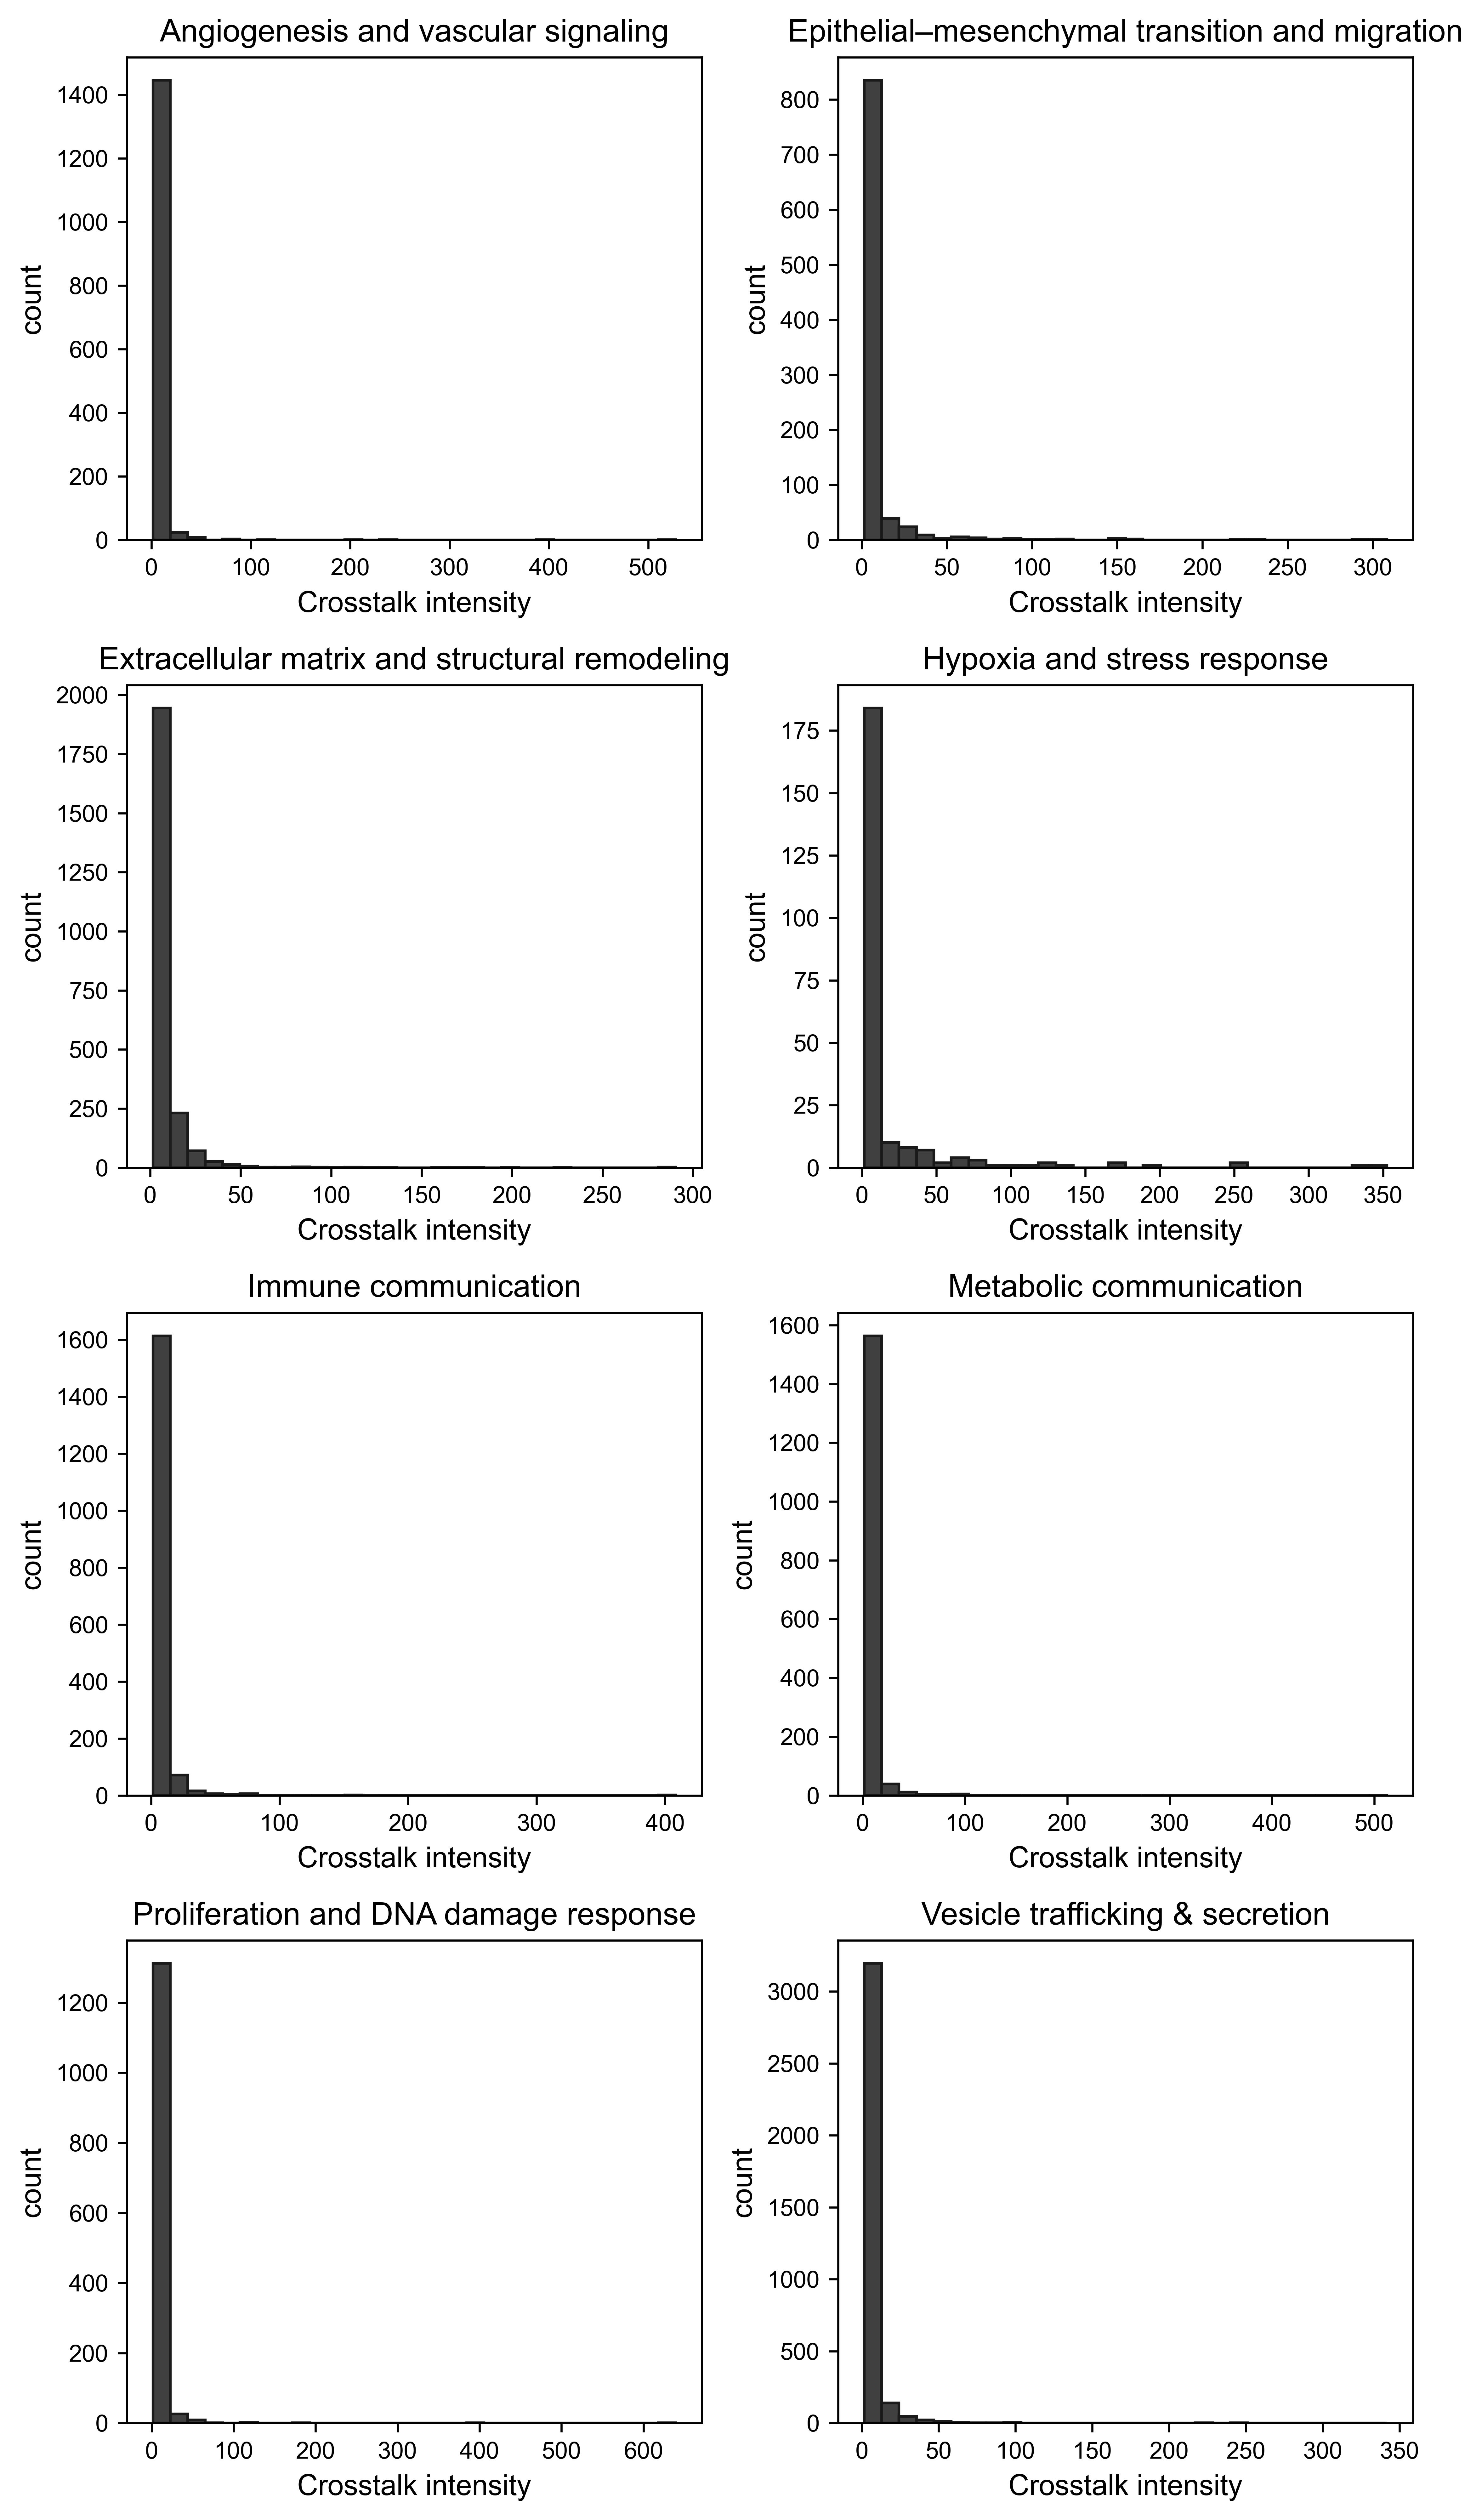

In [15]:
# -------- 1) z-distribution histograms --------
import numpy as np
import matplotlib.pyplot as plt

_need(edge_df, ["z","channel"])
sub = edge_df.loc[edge_df["z"] >= Z_MIN].copy()

nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 14), squeeze=False)
# fig.suptitle(f"Edge z-distributions (z ≥ {Z_MIN})", y=0.995, fontsize=13)

for k, ch in enumerate(channels):
    ax = axes[k//ncols, k % ncols]
    z = sub.loc[sub["channel"]==ch, "z"].to_numpy()
    if z.size == 0:
        ax.text(0.5, 0.5, "no edges", ha="center", va="center")
    else:
        ax.hist(z, bins=30, color="0.25", edgecolor="0.1")
    ax.set_title(ch, pad=6)
    ax.set_xlabel("Crosstalk intensity"); ax.set_ylabel("count")

for kk in range(len(channels), nrows*ncols):
    axes[kk//ncols, kk % ncols].axis("off")

plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

outfile=f"/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/edge_intensity_distribution.pdf"
plt.savefig(outfile, bbox_inches="tight")

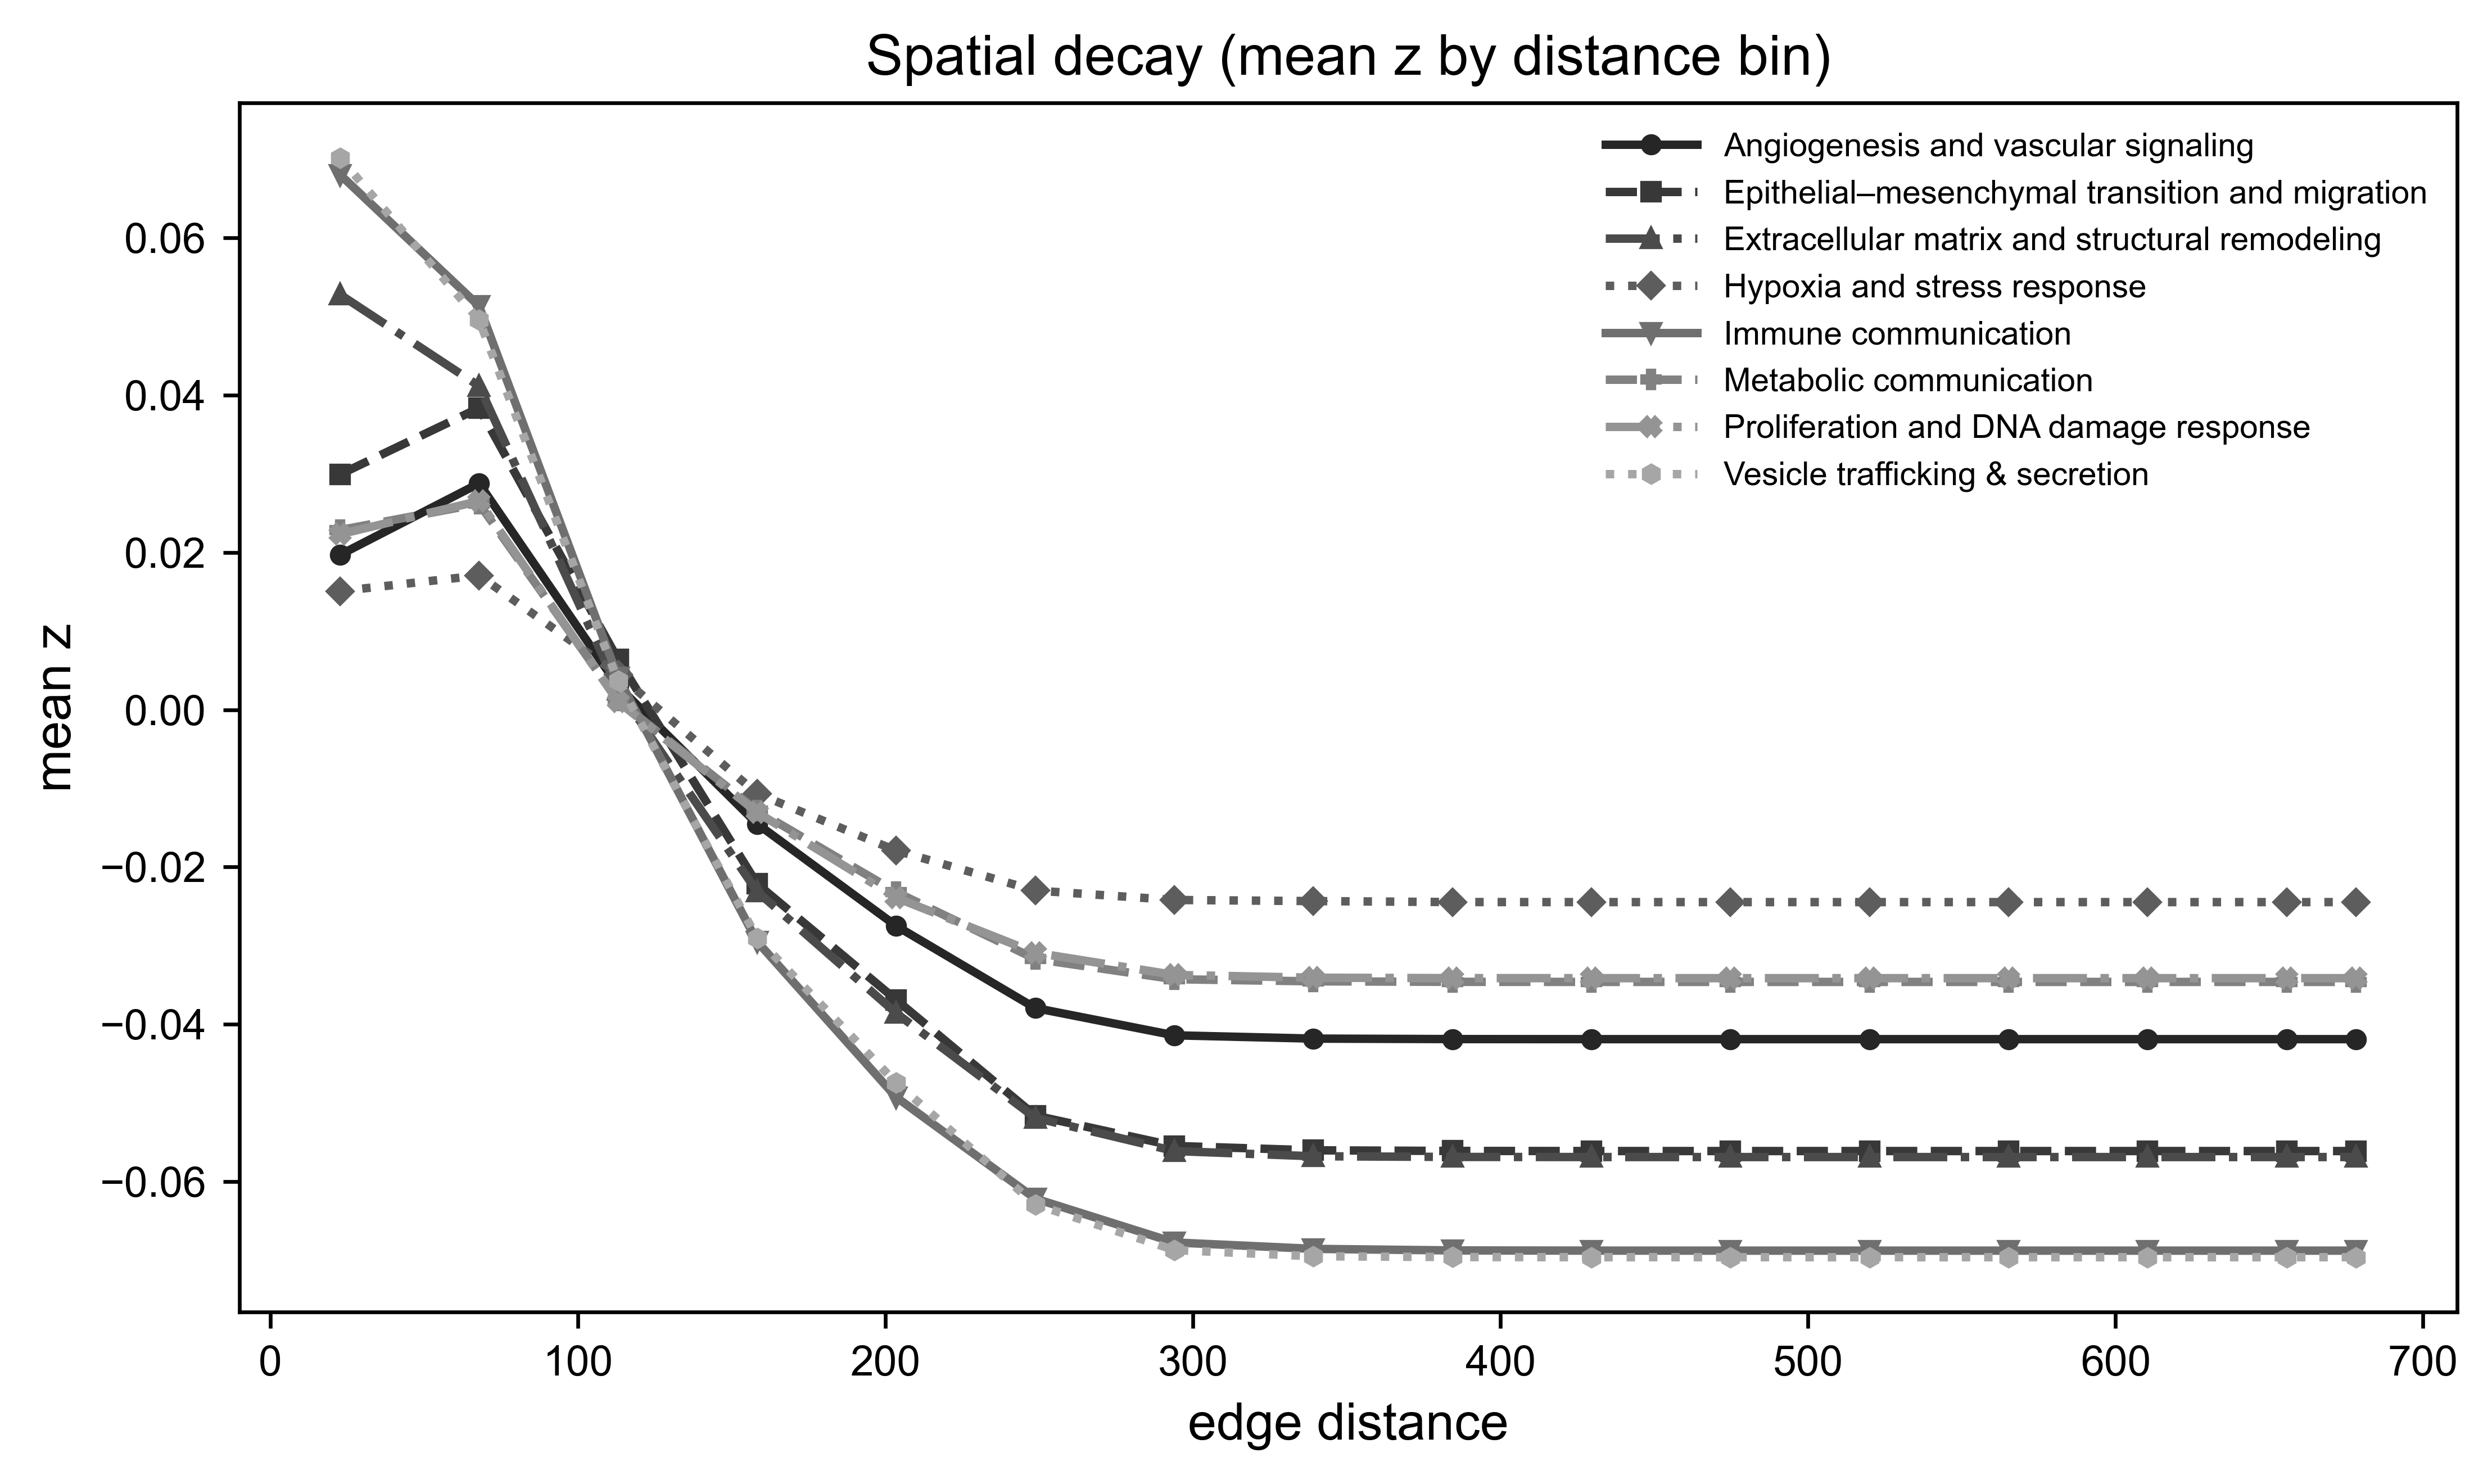

In [16]:
# -------- 2) spatial decay (mean z vs distance) — all channels, B/W styles --------
_need(edge_df, ["distance","z","channel"])

BINS_DISTANCE = 16
bins = np.linspace(0, edge_df["distance"].max(), BINS_DISTANCE)

edf = edge_df.copy()
edf["_bin"] = np.digitize(edf["distance"].values, bins)

# B/W-friendly style cycles
line_styles  = ['-', '--', '-.', ':', '-', '--', '-.', ':']
markers      = ['o', 's', '^', 'D', 'v', 'P', 'X', 'h']
gray_levels  = np.linspace(0.15, 0.65, num=len(channels))  # darker→lighter

fig, ax = plt.subplots(figsize=(7.5, 4.5))
for k, ch in enumerate(channels):
    sub = edf.loc[edf["channel"] == ch]
    if sub.empty:
        continue
    prof = sub.groupby("_bin")["z"].mean()
    if prof.empty:
        continue
    centers = _bin_centers(bins, prof.index.to_numpy())
    # align x/y in case the first bin is empty
    ax.plot(
        centers, prof.values,
        linestyle=line_styles[k % len(line_styles)],
        marker=markers[k % len(markers)],
        markersize=3.5,
        linewidth=1.8,
        color=str(gray_levels[k]),
        label=ch
    )

ax.set_xlabel("edge distance")
ax.set_ylabel("mean z")
ax.set_title("Spatial decay (mean z by distance bin)")
# compact legend, multi-column if long
leg = ax.legend(frameon=False, fontsize=7, ncol=1, handlelength=2.8, columnspacing=1.2)
plt.tight_layout()

outfile=f"/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/edge_intensity_decaying_across_distance.pdf"
plt.savefig(outfile, bbox_inches="tight")


[Boundary table]
 etype                                            Interface↔Interface  TME↔TME  \
channel                                                                         
Angiogenesis and vascular signaling                            4.047    4.738   
Epithelial–mesenchymal transition and migration               11.498    6.430   
Extracellular matrix and structural remodeling                 4.893    8.110   
Hypoxia and stress response                                   24.271   12.155   
Immune communication                                           5.646    6.665   
Metabolic communication                                        5.461    4.765   
Proliferation and DNA damage response                          6.906    6.943   
Vesicle trafficking & secretion                                6.104    5.617   

etype                                            Tumor↔Tumor   cross  
channel                                                               
Angiogenesis and vascular si

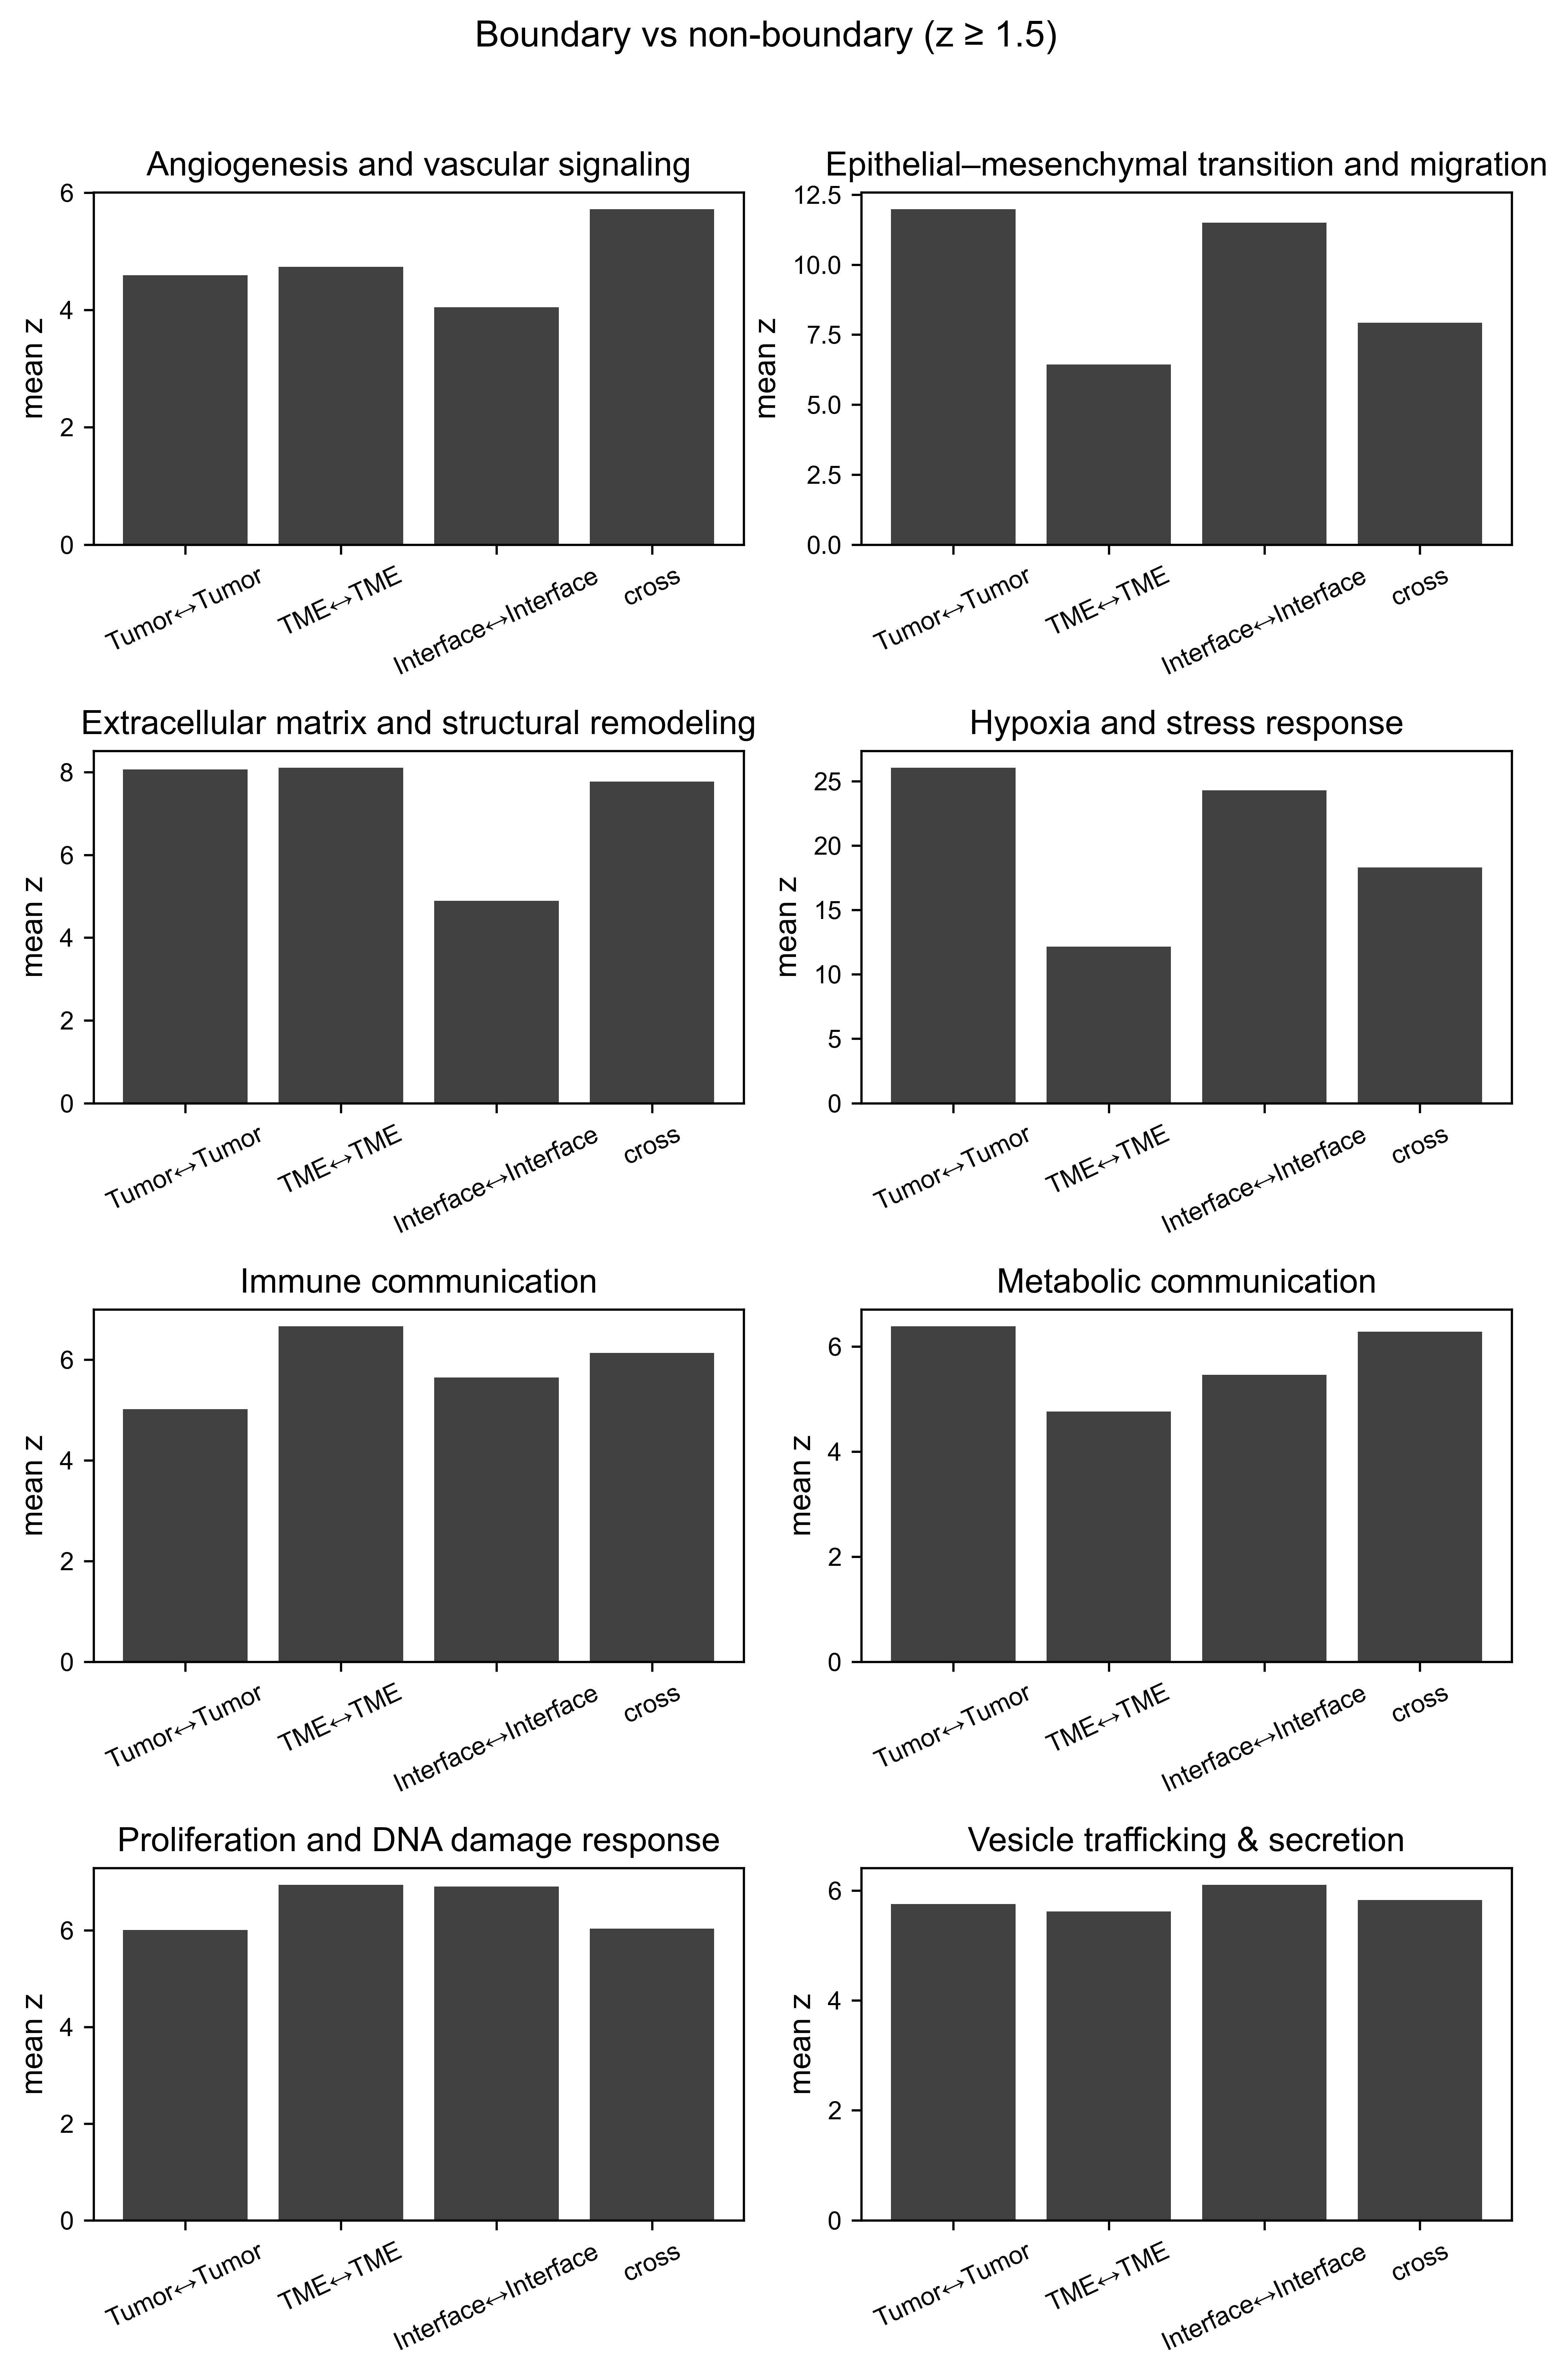

In [17]:
# -------- 3) boundary vs non-boundary --------
_need(edge_df, ["i","j","channel","z"])
assert "compartment" in adata.obs.columns, "adata.obs['compartment'] is required."

comp = adata.obs["compartment"].astype(str).values
strong = edge_df.loc[edge_df["z"] >= Z_MIN].copy()

def _etype(i, j):
    a, b = comp[i], comp[j]
    return "cross" if a != b else f"{a}↔{b}"

strong["etype"] = [ _etype(i,j) for i,j in strong[["i","j"]].to_numpy() ]
tab = (strong.groupby(["channel","etype"])["z"]
             .mean().unstack(fill_value=0.0))

# per-channel bar panels (consistent B/W)
order = [c for c in ["Tumor↔Tumor","TME↔TME","Interface↔Interface","cross"] if c in tab.columns]
nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 12), squeeze=False)
fig.suptitle(f"Boundary vs non-boundary (z ≥ {Z_MIN})", y=0.995, fontsize=13)

for k, ch in enumerate(channels):
    ax = axes[k//ncols, k % ncols]
    if ch in tab.index:
        vals = tab.loc[ch, order]
        ax.bar(np.arange(len(order)), vals, color="0.25")
        ax.set_xticks(range(len(order))); ax.set_xticklabels(order, rotation=25)
        ax.set_ylabel("mean z"); ax.set_title(ch, pad=6)
    else:
        ax.text(0.5,0.5,"no edges",ha="center",va="center")

plt.tight_layout(rect=[0.02,0.02,0.98,0.98])

# cross - within summary (optional print/table)
within_cols = [c for c in tab.columns if c != "cross"]
contrast = (tab["cross"] - tab[within_cols].mean(axis=1)).sort_values(ascending=False)
print("\n[Boundary table]\n", tab.round(3))
print("\n[Cross - within] (boundary enrichment if >0)\n", contrast.round(3))

outfile=f"/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/boundary_nonboundary_talk_intensity.pdf"
plt.savefig(outfile, bbox_inches="tight")

In [ ]:
# # -------- cell-type ↔ cell-type enrichment (better normalized) --------
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# Z_MIN = 1.5  # keep consistent with your edge filter

# def ct_pair_matrices(edge_df, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=False):
#     # 1) pick a CT column
#     ct_key = None
#     for k in ["cell_type","celltype","cell_type_major","__ct","ct","author_cell_type"]:
#         if k in adata.obs.columns: ct_key = k; break
#     if ct_key is None:
#         raise ValueError("No cell-type column found in adata.obs.")
#     ct = adata.obs[ct_key].astype(str).values

#     # 2) optionally restrict to cross-compartment
#     df = edge_df[edge_df["z"] >= z_min].copy()
#     if cross_only and "compartment" in adata.obs.columns:
#         comp = adata.obs["compartment"].astype(str).values
#         is_cross = (comp[df["i"].values] != comp[df["j"].values])
#         df = df.loc[is_cross].copy()

#     # 3) choose top CTs by total participation
#     all_nodes = np.r_[df["i"].values, df["j"].values]
#     top_names = pd.Series(ct[all_nodes]).value_counts().head(top_ct).index.tolist()
#     name_to_idx = {n:i for i,n in enumerate(top_names)}
#     n_ct = len(top_names)

#     # 4) precompute group sizes (for normalization by opportunities)
#     n_by_ct = pd.Series(ct).value_counts()
#     nA = np.array([n_by_ct.get(n, 0) for n in top_names], dtype=float)

#     # 5) build three matrices per channel
#     out = {}
#     for ch in channels:
#         sub = df.loc[df["channel"] == ch]
#         if sub.empty:
#             out[ch] = dict(counts=np.zeros((n_ct,n_ct)),
#                            density=np.zeros((n_ct,n_ct)),
#                            meanz=np.zeros((n_ct,n_ct)))
#             continue

#         C = np.zeros((n_ct, n_ct), dtype=float)   # raw counts
#         Z = np.zeros((n_ct, n_ct), dtype=float)   # sum z to compute mean z later
#         N = np.zeros((n_ct, n_ct), dtype=float)   # number of edges for mean z

#         I = sub["i"].to_numpy(); J = sub["j"].to_numpy()
#         z = sub["z"].to_numpy()

#         for ii, jj, zz in zip(I, J, z):
#             a_name, b_name = ct[ii], ct[jj]
#             if (a_name not in name_to_idx) or (b_name not in name_to_idx):
#                 continue
#             a, b = name_to_idx[a_name], name_to_idx[b_name]
#             if a > b: a, b = b, a  # undirected bin
#             C[a, b] += 1.0
#             Z[a, b] += zz
#             N[a, b] += 1.0

#         # symmetrize (since undirected)
#         C = C + C.T - np.diag(np.diag(C))
#         Z = Z + Z.T - np.diag(np.diag(Z))
#         N = N + N.T - np.diag(np.diag(N))

#         # mean z (avoid divide-by-zero)
#         meanz = np.divide(Z, N, out=np.zeros_like(Z), where=N>0)

#         # density per 10k potential pairs
#         # potential pairs ≈ nA[a]*nA[b] for a!=b; and nA[a]*(nA[a]-1)/2 for a==b (but we symmetrize, so use nA[a]*nA[b] with a<=b then symmetrize)
#         opp = np.zeros_like(C)
#         for a in range(n_ct):
#             for b in range(n_ct):
#                 if a == b:
#                     opp[a,b] = nA[a]*max(nA[a]-1,0)/2.0
#                 else:
#                     opp[a,b] = nA[a]*nA[b]
#         opp = opp + opp.T - np.diag(np.diag(opp))
#         density = np.divide(C, opp, out=np.zeros_like(C), where=opp>0) * 1e4  # per 10k opportunities

#         out[ch] = dict(counts=C, density=density, meanz=meanz)

#     return top_names, out

# def plot_ct_pair_panels(top_names, mats_by_ch, title_suffix="", vmax_quant=0.98):
#     # render three grids: raw counts (clipped), density, mean z
#     n_ct = len(top_names)
#     chans = list(mats_by_ch.keys())

#     for metric in ["counts","density","meanz"]:
#         fig, axes = plt.subplots(4, 2, figsize=(9, 12), squeeze=False)
#         fig.suptitle(f"Cell-type pair {metric} {title_suffix}", y=0.995, fontsize=13)
#         for k, ch in enumerate(chans):
#             ax = axes[k//2, k%2]
#             A = mats_by_ch[ch][metric]
#             # robust grayscale range
#             finite_vals = A[np.isfinite(A)]
#             vmax = np.quantile(finite_vals[finite_vals>0], vmax_quant) if np.any(finite_vals>0) else 1.0
#             im = ax.imshow(np.clip(A, 0, vmax), cmap="Greys", vmin=0, vmax=vmax, interpolation="nearest")
#             ax.set_title(ch, pad=6)
#             ax.set_xticks(range(n_ct)); ax.set_yticks(range(n_ct))
#             ax.set_xticklabels(top_names, rotation=80, ha="right", fontsize=7)
#             ax.set_yticklabels(top_names, fontsize=7)
#         plt.tight_layout(rect=[0.02,0.02,0.98,0.98])

# def print_top_pairs(edge_df, adata, channels, z_min=Z_MIN, k=10):
#     # quick text table of strongest pairs per channel
#     ct_key = None
#     for kk in ["cell_type","celltype","cell_type_major","__ct","ct","author_cell_type"]:
#         if kk in adata.obs.columns: ct_key = kk; break
#     ct = adata.obs[ct_key].astype(str).values
#     strong = edge_df[edge_df["z"] >= z_min].copy()
#     for ch in channels:
#         sub = strong[strong["channel"]==ch]
#         if sub.empty: continue
#         pairs = []
#         for i,j in sub[["i","j"]].to_numpy():
#             a, b = ct[i], ct[j]
#             if a > b: a, b = b, a
#             pairs.append((a,b))
#         s = pd.Series(pairs).value_counts().head(k)
#         print(f"\n[{ch}] top {k} pairs by count:")
#         print(s)

# # --- Run (all edges with z≥1.5) ---
# edge_strong = edge_df[edge_df["z"] >= Z_MIN].copy()

# # A) all edges
# top_names, mats = ct_pair_matrices(edge_strong, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=False)
# plot_ct_pair_panels(top_names, mats, title_suffix="(all edges)", vmax_quant=0.98)
# print_top_pairs(edge_strong, adata, channels, z_min=Z_MIN, k=10)

# # B) cross-compartment only (optional, very informative for boundary biology)
# if "compartment" in adata.obs.columns:
#     top_names_x, mats_x = ct_pair_matrices(edge_strong, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=True)
#     plot_ct_pair_panels(top_names_x, mats_x, title_suffix="(cross-compartment only)", vmax_quant=0.98)

In [ ]:
# ================= SAVE-ENABLED CT↔CT ENRICHMENT PANELS =================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Z_MIN = 1.5  # keep consistent with your edge filter
SAVE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures"
os.makedirs(SAVE_DIR, exist_ok=True)

def ct_pair_matrices(edge_df, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=False):
    # 1) pick a CT column
    ct_key = None
    for k in ["cell_type","celltype","cell_type_major","__ct","ct","author_cell_type"]:
        if k in adata.obs.columns: ct_key = k; break
    if ct_key is None:
        raise ValueError("No cell-type column found in adata.obs.")
    ct = adata.obs[ct_key].astype(str).values

    # 2) optionally restrict to cross-compartment
    df = edge_df[edge_df["z"] >= z_min].copy()
    if cross_only and "compartment" in adata.obs.columns:
        comp = adata.obs["compartment"].astype(str).values
        is_cross = (comp[df["i"].values] != comp[df["j"].values])
        df = df.loc[is_cross].copy()

    # 3) choose top CTs by total participation
    all_nodes = np.r_[df["i"].values, df["j"].values]
    top_names = pd.Series(ct[all_nodes]).value_counts().head(top_ct).index.tolist()
    name_to_idx = {n:i for i,n in enumerate(top_names)}
    n_ct = len(top_names)

    # 4) precompute group sizes (for normalization by opportunities)
    n_by_ct = pd.Series(ct).value_counts()
    nA = np.array([n_by_ct.get(n, 0) for n in top_names], dtype=float)

    # 5) build three matrices per channel
    out = {}
    for ch in channels:
        sub = df.loc[df["channel"] == ch]
        if sub.empty:
            out[ch] = dict(counts=np.zeros((n_ct,n_ct)),
                           density=np.zeros((n_ct,n_ct)),
                           meanz=np.zeros((n_ct,n_ct)))
            continue

        C = np.zeros((n_ct, n_ct), dtype=float)   # raw counts
        Z = np.zeros((n_ct, n_ct), dtype=float)   # sum z to compute mean z later
        N = np.zeros((n_ct, n_ct), dtype=float)   # number of edges for mean z

        I = sub["i"].to_numpy(); J = sub["j"].to_numpy()
        z = sub["z"].to_numpy()

        for ii, jj, zz in zip(I, J, z):
            a_name, b_name = ct[ii], ct[jj]
            if (a_name not in name_to_idx) or (b_name not in name_to_idx):
                continue
            a, b = name_to_idx[a_name], name_to_idx[b_name]
            if a > b: a, b = b, a  # undirected bin
            C[a, b] += 1.0
            Z[a, b] += zz
            N[a, b] += 1.0

        # symmetrize (since undirected)
        C = C + C.T - np.diag(np.diag(C))
        Z = Z + Z.T - np.diag(np.diag(Z))
        N = N + N.T - np.diag(np.diag(N))

        # mean z (avoid divide-by-zero)
        meanz = np.divide(Z, N, out=np.zeros_like(Z), where=N>0)

        # opportunities normalization (density per 10k possible pairs)
        opp = np.zeros_like(C)
        for a in range(n_ct):
            for b in range(n_ct):
                if a == b:
                    opp[a,b] = nA[a]*max(nA[a]-1,0)/2.0
                else:
                    opp[a,b] = nA[a]*nA[b]
        opp = opp + opp.T - np.diag(np.diag(opp))
        density = np.divide(C, opp, out=np.zeros_like(C), where=opp>0) * 1e4  # per 10k opportunities

        out[ch] = dict(counts=C, density=density, meanz=meanz)

    return top_names, out

def plot_ct_pair_panels(top_names, mats_by_ch, *, title_suffix="", vmax_quant=0.98,
                        save_dir=SAVE_DIR, filename_prefix="ct_pairs"):
    """
    Saves three figure grids:
      - counts heatmaps
      - density heatmaps
      - meanz heatmaps
    Filenames include title_suffix and vmax_quant.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_ct = len(top_names)
    chans = list(mats_by_ch.keys())

    filepaths = {}

    for metric in ["counts","density","meanz"]:
        fig, axes = plt.subplots(4, 2, figsize=(9, 12), squeeze=False)
        fig.suptitle(f"Cell-type pair {metric} {title_suffix}".strip(), y=0.995, fontsize=13)

        for k, ch in enumerate(chans):
            ax = axes[k//2, k%2]
            A = mats_by_ch[ch][metric]
            finite_vals = A[np.isfinite(A)]
            vmax = np.quantile(finite_vals[finite_vals>0], vmax_quant) if np.any(finite_vals>0) else 1.0
            im = ax.imshow(np.clip(A, 0, vmax), cmap="Greys", vmin=0, vmax=vmax, interpolation="nearest")
            ax.set_title(ch, pad=6)
            ax.set_xticks(range(n_ct)); ax.set_yticks(range(n_ct))
            ax.set_xticklabels(top_names, rotation=80, ha="right", fontsize=7)
            ax.set_yticklabels(top_names, fontsize=7)

        plt.tight_layout(rect=[0.02,0.02,0.98,0.98])

        safe_suffix = title_suffix.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "-")
        fname = f"{filename_prefix}_{metric}_{safe_suffix}_vmaxq{vmax_quant:.2f}.pdf"
        fpath = os.path.join(save_dir, fname)
        plt.savefig(fpath, bbox_inches="tight", dpi=600)
        plt.close(fig)
        filepaths[metric] = fpath

    return filepaths

def print_top_pairs(edge_df, adata, channels, z_min=Z_MIN, k=10):
    ct_key = None
    for kk in ["cell_type","celltype","cell_type_major","__ct","ct","author_cell_type"]:
        if kk in adata.obs.columns: ct_key = kk; break
    ct = adata.obs[ct_key].astype(str).values
    strong = edge_df[edge_df["z"] >= z_min].copy()
    for ch in channels:
        sub = strong[strong["channel"]==ch]
        if sub.empty: continue
        pairs = []
        for i,j in sub[["i","j"]].to_numpy():
            a, b = ct[i], ct[j]
            if a > b: a, b = b, a
            pairs.append((a,b))
        s = pd.Series(pairs).value_counts().head(k)
        print(f"\n[{ch}] top {k} pairs by count:")
        print(s)

# ------------------ Run & Save ------------------
edge_strong = edge_df[edge_df["z"] >= Z_MIN].copy()

# A) all edges
top_names, mats = ct_pair_matrices(edge_strong, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=False)
paths_all = plot_ct_pair_panels(top_names, mats, title_suffix="(all edges)", vmax_quant=0.98,
                                save_dir=SAVE_DIR, filename_prefix="ct_pairs_all")
print_top_pairs(edge_strong, adata, channels, z_min=Z_MIN, k=10)
print("Saved (all edges):", paths_all)

# B) cross-compartment only
if "compartment" in adata.obs.columns:
    top_names_x, mats_x = ct_pair_matrices(edge_strong, adata, channels, z_min=Z_MIN, top_ct=12, cross_only=True)
    paths_cross = plot_ct_pair_panels(top_names_x, mats_x, title_suffix="(cross-compartment only)", vmax_quant=0.98,
                                      save_dir=SAVE_DIR, filename_prefix="ct_pairs_cross")
    print("Saved (cross-compartment):", paths_cross)

In [ ]:
# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # === Setup ===
# comp = adata.obs["compartment"].astype(str)
# ct = adata.obs["author_cell_type"].astype(str)

# # Ensure edge_df has indices
# i, j = edge_df["i"].values, edge_df["j"].values
# edge_df["comp_i"] = comp.iloc[i].values
# edge_df["comp_j"] = comp.iloc[j].values
# edge_df["ct_i"] = ct.iloc[i].values
# edge_df["ct_j"] = ct.iloc[j].values

# # ----------------------------
# # 1️⃣ Normalize by expected edge count per compartment pair
# # ----------------------------
# def _comp_enrichment(edge_df, n_null=100):
#     obs = (edge_df.groupby(["channel", "comp_i", "comp_j"])
#                    .size().unstack(["comp_i","comp_j"], fill_value=0))
#     exp_accum = np.zeros_like(obs, dtype=float)

#     for _ in range(n_null):
#         perm = np.random.permutation(comp.values)
#         df_null = edge_df.copy()
#         df_null["comp_i"] = perm[i]
#         df_null["comp_j"] = perm[j]
#         exp = (df_null.groupby(["channel","comp_i","comp_j"])
#                        .size().unstack(["comp_i","comp_j"], fill_value=0))
#         exp_accum += exp.reindex_like(obs).fillna(0)

#     exp_mean = exp_accum / n_null
#     enrich = (obs / (exp_mean + 1e-8))
#     return enrich

# enrich = _comp_enrichment(edge_df)

# # Plot enrichment as heatmap per channel
# for ch in enrich.index:
#     mat = enrich.loc[ch]
#     plt.figure(figsize=(3.5,3))
#     sns.heatmap(np.log2(mat+1e-8), cmap="gray_r", annot=True, fmt=".2f",
#                 cbar=False)
#     plt.title(f"{ch}\nlog₂ enrichment (observed/expected)")
#     plt.tight_layout()

# # ----------------------------
# # 2️⃣ Normalize by total edges per cell type
# # ----------------------------
# def _ct_participation(edge_df):
#     counts = []
#     for ch, sub in edge_df.groupby("channel"):
#         cts = pd.concat([sub["ct_i"], sub["ct_j"]]).value_counts()
#         cts = cts / cts.sum()
#         counts.append(cts.rename(ch))
#     return pd.DataFrame(counts).fillna(0)

# partic = _ct_participation(edge_df)

# plt.figure(figsize=(10,5))
# sns.heatmap(partic, cmap="gray_r", cbar=True)
# plt.title("Relative edge participation per cell type (normalized per channel)")
# plt.xlabel("cell type"); plt.ylabel("channel")
# plt.tight_layout()

In [ ]:
# # -------- 5) spatial permutation null (fast) --------
# _need(edge_df, ["i","j","channel","score_raw","z"])
# XY = np.asarray(adata.obsm["spatial"], dtype=float)

# # use sigma from your Phase-2 build if stored; else estimate from current edges
# if "distance" in edge_df.columns:
#     SIGMA = float(np.median(edge_df["distance"].values))
# else:
#     SIGMA = 1.0
# # ---------------- Spatial permutation null (fixed standardization) ----------------
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def spatial_perm_null_fixed_z(edge_df, XY, sigma, Z_MIN=1.5, n_perm=200, seed=0):
#     """Compare boundary/CCC strength to a spatial null with frozen z-standardization.

#     edge_df must have: ['i','j','channel','score_raw','score_weighted'] and ideally 'distance'.
#     XY: Nx2 coordinates used to compute spatial weights w = exp(-(d^2)/(sigma^2))
#     sigma: spatial kernel sigma (use your median edge length)
#     """
#     rng = np.random.default_rng(seed)

#     # 1) Freeze μ,σ from the *observed* score_weighted per channel
#     mu = edge_df.groupby("channel")["score_weighted"].mean()
#     sd = edge_df.groupby("channel")["score_weighted"].std().replace(0, 1.0)
#     mu_sd = pd.concat({"mu": mu, "sd": sd}, axis=1)

#     # Observed frozen-z and stats
#     obs = edge_df[["channel","score_weighted"]].copy()
#     obs = obs.join(mu_sd, on="channel")
#     obs["z_frozen"] = (obs["score_weighted"] - obs["mu"]) / obs["sd"]

#     def frac_tail(s):    # fraction z >= Z_MIN
#         return np.mean(s >= Z_MIN) if len(s) else np.nan
#     def pos_tail_mean(s):  # mean z over z>0 (or over z>=Z_MIN)
#         s = s[s > 0]
#         return s.mean() if len(s) else 0.0

#     obs_frac  = obs.groupby("channel")["z_frozen"].apply(frac_tail)
#     obs_pmean = obs.groupby("channel")["z_frozen"].apply(pos_tail_mean)

#     # 2) Precompute pairs
#     I = edge_df["i"].to_numpy()
#     J = edge_df["j"].to_numpy()
#     raw = edge_df["score_raw"].to_numpy()
#     ch = edge_df["channel"].to_numpy()

#     def w_from_xy(XY_):
#         dx = XY_[I,0] - XY_[J,0]
#         dy = XY_[I,1] - XY_[J,1]
#         D = np.sqrt(dx*dx + dy*dy)
#         return np.exp(-(D*D)/(sigma*sigma))

#     # 3) Null distributions under spatial shuffles (permute coordinates)
#     null_frac  = {c: [] for c in mu.index}
#     null_pmean = {c: [] for c in mu.index}

#     for _ in range(n_perm):
#         XYp = XY[rng.permutation(XY.shape[0])]
#         w   = w_from_xy(XYp)
#         swp = raw * w  # new score_weighted under shuffle

#         tmp = pd.DataFrame({"channel": ch, "swp": swp})
#         tmp = tmp.join(mu_sd, on="channel")
#         tmp["z_frozen"] = (tmp["swp"] - tmp["mu"]) / tmp["sd"]

#         frac = tmp.groupby("channel")["z_frozen"].apply(frac_tail)
#         pmean = tmp.groupby("channel")["z_frozen"].apply(pos_tail_mean)

#         for c in mu.index:
#             null_frac[c].append(frac.get(c, np.nan))
#             null_pmean[c].append(pmean.get(c, np.nan))

#     # 4) Plot: boxplot null + observed dot, for both stats
#     stats = [("Tail fraction (z ≥ {:.1f})".format(Z_MIN), null_frac, obs_frac),
#              ("Positive-tail mean z", null_pmean, obs_pmean)]

#     for title, null_dict, obs_series in stats:
#         fig, axes = plt.subplots(4, 2, figsize=(8, 12), squeeze=False)
#         fig.suptitle(f"Spatial permutation null (n={n_perm}) — {title}", y=0.995, fontsize=13)
#         ch_list = list(mu.index)
#         for k, c in enumerate(ch_list):
#             ax = axes[k//2, k%2]
#             vals = np.array(null_dict[c], float)
#             vals = vals[~np.isnan(vals)]
#             if vals.size == 0:
#                 ax.text(0.5,0.5,"no null",ha="center",va="center"); ax.set_xticks([]); continue

#             ax.boxplot(vals, vert=True, patch_artist=True,
#                        boxprops=dict(facecolor="0.85", color="0.25"),
#                        medianprops=dict(color="0.25"))
#             ax.scatter([1], [obs_series.get(c, np.nan)], color="0.1", zorder=3)
#             ax.set_title(c, pad=6); ax.set_xticks([]); ax.set_ylabel(title)

#             # one-sided p-value (right tail if obs >= null median else left tail)
#             if np.isfinite(obs_series.get(c, np.nan)):
#                 if obs_series[c] >= np.nanmedian(vals):
#                     p = (np.sum(vals >= obs_series[c]) + 1) / (len(vals) + 1)
#                 else:
#                     p = (np.sum(vals <= obs_series[c]) + 1) / (len(vals) + 1)
#                 ax.text(0.05, 0.92, f"p={p:.3f}", transform=ax.transAxes, fontsize=9)
#         plt.tight_layout(rect=[0.02,0.02,0.98,0.98])

#     # Return the raw numbers if you want to tabulate later
#     return {
#         "obs_frac":  obs_frac,
#         "obs_pmean": obs_pmean,
#         "null_frac":  pd.DataFrame(null_frac),
#         "null_pmean": pd.DataFrame(null_pmean),
#     }

# # ---- run it (reuse the sigma you printed earlier from edges) ----
# perm_out = spatial_perm_null_fixed_z(
#     edge_df=edge_df, XY=np.asarray(adata.obsm["spatial"], float),
#     sigma=SIGMA, Z_MIN=2.5, n_perm=200, seed=2
# )

In [ ]:
# use sigma from your Phase-2 build if stored; else estimate from current edges
if "distance" in edge_df.columns:
    SIGMA = float(np.median(edge_df["distance"].values))
else:
    SIGMA = 1.0

def spatial_perm_tail_fraction_only(
    edge_df, XY, sigma,
    Z_MIN=1.5, n_perm=200, seed=0,
    savepath=None  # <---- NEW
):
    """
    Spatial permutation null with frozen z-standardization.
    Plots only the tail fraction Pr[z >= Z_MIN] per channel and saves if path given.
    """
    rng = np.random.default_rng(seed)

    # Freeze μ,σ from observed data
    mu = edge_df.groupby("channel")["score_weighted"].mean()
    sd = edge_df.groupby("channel")["score_weighted"].std().replace(0, 1.0)
    mu_sd = pd.concat({"mu": mu, "sd": sd}, axis=1)

    # Observed z_frozen
    obs = edge_df[["channel","score_weighted"]].copy().join(mu_sd, on="channel")
    obs["z_frozen"] = (obs["score_weighted"] - obs["mu"]) / obs["sd"]

    def frac_tail(s): return np.mean(s >= Z_MIN) if len(s) else np.nan
    obs_frac = obs.groupby("channel")["z_frozen"].apply(frac_tail)

    # Precompute pairs
    I, J = edge_df["i"].to_numpy(), edge_df["j"].to_numpy()
    raw, chans = edge_df["score_raw"].to_numpy(), edge_df["channel"].to_numpy()

    def w_from_xy(coord):
        dx, dy = coord[I,0] - coord[J,0], coord[I,1] - coord[J,1]
        D = np.sqrt(dx*dx + dy*dy)
        return np.exp(-(D*D)/(sigma*sigma))

    # Null draws
    null_frac = {c: [] for c in mu.index}
    for _ in range(n_perm):
        XYp = XY[rng.permutation(XY.shape[0])]
        swp = raw * w_from_xy(XYp)
        tmp = pd.DataFrame({"channel": chans, "swp": swp}).join(mu_sd, on="channel")
        tmp["z_frozen"] = (tmp["swp"] - tmp["mu"]) / tmp["sd"]
        frac = tmp.groupby("channel")["z_frozen"].apply(frac_tail)
        for c in mu.index:
            null_frac[c].append(frac.get(c, np.nan))

    # Compute one-sided permutation p-values
    pvals = {}
    for c in mu.index:
        vals = np.array(null_frac[c], float)
        vals = vals[~np.isnan(vals)]
        if vals.size == 0 or not np.isfinite(obs_frac.get(c, np.nan)):
            pvals[c] = np.nan
            continue
        if obs_frac[c] >= np.nanmedian(vals):
            p = (np.sum(vals >= obs_frac[c]) + 1) / (len(vals) + 1)
        else:
            p = (np.sum(vals <= obs_frac[c]) + 1) / (len(vals) + 1)
        pvals[c] = p

    # --- Plot
    fig, axes = plt.subplots(4, 2, figsize=(8, 12), squeeze=False)
    fig.suptitle(f"Spatial permutation null (n={n_perm}) — Tail fraction (z ≥ {Z_MIN})", y=0.995, fontsize=13)
    for k, c in enumerate(mu.index):
        ax = axes[k//2, k%2]
        vals = np.array(null_frac[c], float)
        vals = vals[~np.isnan(vals)]
        if vals.size == 0:
            ax.text(0.5,0.5,"no null",ha="center",va="center"); ax.set_xticks([]); continue
        ax.boxplot(vals, vert=True, patch_artist=True,
                   boxprops=dict(facecolor="0.85", color="0.25"),
                   medianprops=dict(color="0.25"))
        ax.scatter([1], [obs_frac.get(c, np.nan)], color="0.1", zorder=3)
        ax.set_title(c, pad=6); ax.set_xticks([]); ax.set_ylabel("tail fraction")
        pv = pvals.get(c, np.nan)
        if np.isfinite(pv): ax.text(0.05, 0.92, f"p={pv:.3f}", transform=ax.transAxes, fontsize=9)

    plt.tight_layout(rect=[0.02,0.02,0.98,0.98])

    if savepath:
        fname = f"{savepath}/spatial_perm_tail_z{Z_MIN}_perm{n_perm}.pdf"
        plt.savefig(fname, bbox_inches="tight", dpi=600)
        print(f"Saved figure to: {fname}")

    plt.show()
    return {
        "obs_tail_frac": obs_frac.sort_index(),
        "null_tail_frac": pd.DataFrame(null_frac).sort_index(axis=1),
        "pvals": pd.Series(pvals).sort_index()
    }


perm_out = spatial_perm_tail_fraction_only(
    edge_df=edge_df,
    XY=np.asarray(adata.obsm["spatial"], float),
    sigma=SIGMA,
    Z_MIN=1.5,
    n_perm=200,
    seed=2,
    savepath="/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures"
)

/tmp/ipykernel_3544426/161365660.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = sub.groupby("_bin")["z"]
/tmp/ipykernel_3544426/161365660.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = sub.groupby("_bin")["z"]
/tmp/ipykernel_3544426/161365660.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = sub.groupby("_bin")["z"]
/tmp/ipykernel_3544426/161365660.py:66: FutureWarning: The default of observ

      bin_left  bin_right  count
0    -0.000999     11.103   4560
1    11.103000     22.205     28
2    22.205000     33.308    268
3    33.308000     44.411    839
4    44.411000     55.514   1374
5    55.514000     66.616   1438
6    66.616000     77.719   1305
7    77.719000     88.822    912
8    88.822000     99.924    698
9    99.924000    111.027    444
10  111.027000    122.130    352
11  122.130000    133.233    277
12  133.233000    144.335    217
13  144.335000    155.438    151


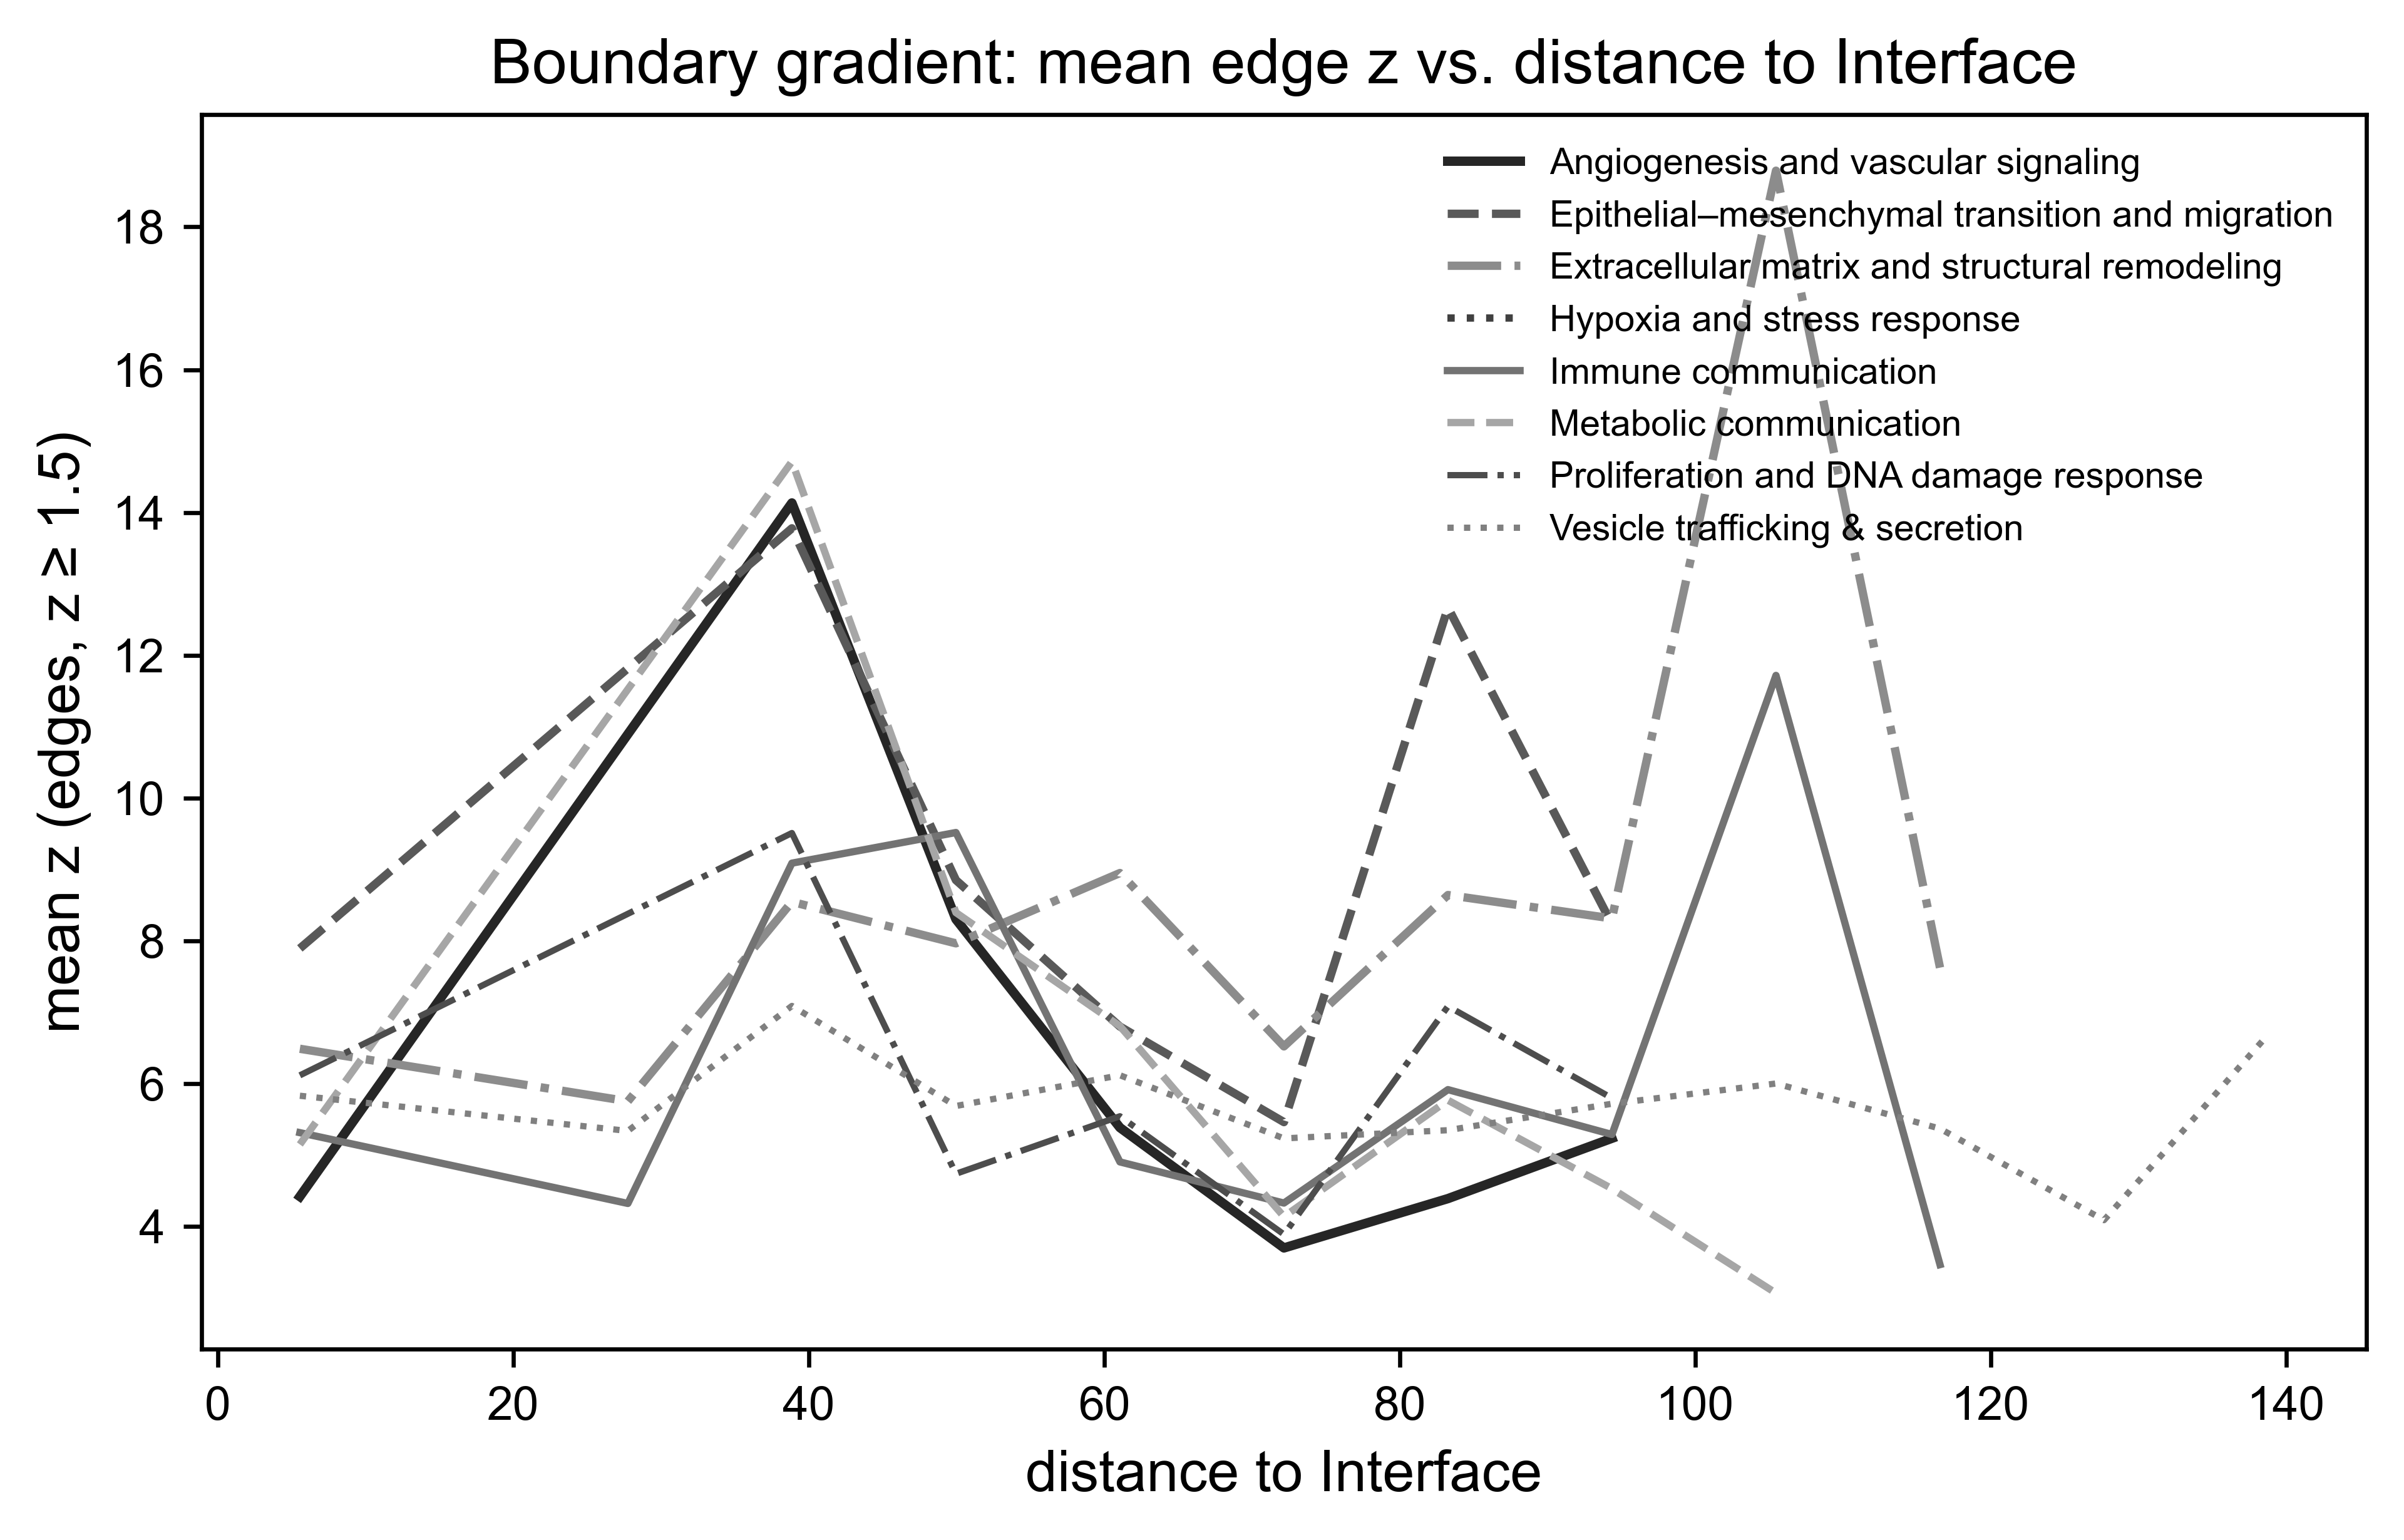

In [18]:
# -------- 6) boundary gradient (mean z vs dist to Interface) — robust --------
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_need(edge_df, ["i","j","channel","z"])
assert "compartment" in adata.obs.columns, "adata.obs['compartment'] is required."
assert "spatial" in adata.obsm, "adata.obsm['spatial'] is required."

Z_MIN = 1.5           # same threshold you used elsewhere
MIN_PER_BIN = 50      # drop very sparse bins so the mean is stable
N_BINS = 14           # number of distance bins (after removing the 0 spike)
EPS = 1e-6            # avoid exact zero distances

XY   = np.asarray(adata.obsm["spatial"], dtype=float)
comp = adata.obs["compartment"].astype(str).values

# distance to nearest Interface cell for every cell
idx_if = np.where(comp == "Interface")[0]
if idx_if.size == 0:
    raise ValueError("No Interface cells found.")

tree = KDTree(XY[idx_if])
d_to_if, _ = tree.query(XY, k=1, return_distance=True, dualtree=True)
d_to_if = d_to_if.ravel().astype(float)

# work on strong edges only (recommended)
df = edge_df.loc[edge_df["z"] >= Z_MIN].copy()
# per-edge distance to Interface = min distance of its endpoints
d_edge = np.minimum(d_to_if[df["i"].values], d_to_if[df["j"].values]) + EPS
df["_d_to_interface"] = d_edge

# make bins robustly (exclude extreme tail to avoid a huge last bin)
d_cap = np.quantile(d_edge, 0.98)
bins = np.linspace(d_edge.min(), d_cap, N_BINS+1)

# use pd.cut for clean categorical bins with centers
cats = pd.cut(df["_d_to_interface"], bins=bins, include_lowest=True)
df["_bin"] = cats

# compute bin centers for plotting
bin_centers = cats.cat.categories.mid

# prepare 8-channel plot (distinct grayscale styles; consistent with your B/W style)
channels_all = sorted(df["channel"].unique())
fig, ax = plt.subplots(figsize=(6.5, 4.2))

styles = [
    dict(color="0.15", lw=1.8),
    dict(color="0.35", lw=1.6, ls="--"),
    dict(color="0.55", lw=1.6, ls="-."),
    dict(color="0.25", lw=1.4, ls=":"),
    dict(color="0.45", lw=1.4),
    dict(color="0.65", lw=1.4, ls="--"),
    dict(color="0.30", lw=1.2, ls="-."),
    dict(color="0.50", lw=1.2, ls=":"),
]

legend_labels = []
for k, ch in enumerate(channels_all[:8]):
    sub = df.loc[df["channel"] == ch]
    if sub.empty:
        continue
    # mean z per bin + drop sparse bins
    gb = sub.groupby("_bin")["z"]
    mean_z = gb.mean()
    counts = gb.size()
    keep = counts >= MIN_PER_BIN
    if keep.sum() == 0:
        continue

    x = bin_centers[keep].values
    y = mean_z[keep].values
    ax.plot(x, y, label=ch, **styles[k % len(styles)])
    legend_labels.append(ch)

ax.set_xlabel("distance to Interface")
ax.set_ylabel("mean z (edges, z ≥ {:.1f})".format(Z_MIN))
ax.set_title("Boundary gradient: mean edge z vs. distance to Interface")
ax.legend(frameon=False, fontsize=7, ncol=1)
plt.tight_layout()

outfile=f"/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/figures/boundary_gradient.pdf"
plt.savefig(outfile, bbox_inches="tight")

print(pd.DataFrame({
    "bin_left": cats.cat.categories.left,
    "bin_right": cats.cat.categories.right,
    "count": df.groupby("_bin").size().reindex(cats.cat.categories).fillna(0).astype(int).values
}))